In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


# Reading in pre-CMIP6 data from cloud storage

In [4]:
col

adhoc-ipcc-ar-ESM Collection with 44 entries:
	> 3 mip_id(s)

	> 1 activity_id(s)

	> 12 institution_id(s)

	> 12 source_id(s)

	> 1 experiment_id(s)

	> 1 member_id(s)

	> 1 table_id(s)

	> 3 variable_id(s)

	> 44 zstore(s)

In [5]:
#  Define the common target grid axes
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 2.)),
                     'lon': (['lon'], np.arange(0.5, 360., 2.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [6]:
mip_ids = ["FAR","SAR","TAR"]
varnames = ['tas','pr']
time_slice = slice('1981', '2010')

ensdict = {}
for varname in tqdm(varnames):
    cat = col.search(experiment_id='historical', 
                     table_id='Amon', 
                     variable_id=varname,
                     member_id='r1i1p1f1')

    dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

    ensdict[varname] = {}
    for key, ds in tqdm(dset_dict.items()):
        # rename spatial dimensions if necessary
        if ('longitude' in ds.dims) and ('latitude' in ds.dims):
            ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        ds = xr.decode_cf(ds)
        ds = ds.squeeze()

        # take 1980-2019 mean
        timeave = ds.sel(time=time_slice).mean(dim='time')  # date range consistent with reanalysis long-term-mean
        timeave = timeave.chunk({'lat':timeave['lat'].size, 'lon':timeave['lon'].size})

        # regrid to common 2deg by 2deg grid
        ds_new = regrid_to_common(timeave[varname], ds_out)

        ds_new.attrs['name'] = ds.attrs['institution']
        ds_new.attrs['mip_id'] = key.split(".")[-1]
        
        # drop redundant variables (like "height: 2m")
        for coord in ds_new.coords:
            if coord not in ['lat','lon']:
                ds_new = ds_new.drop(coord)

        # Add ensemble as new dimension
        ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)

        # Add var as new dimension
        ds_new = ds_new.expand_dims({'var': np.array([varname])}, 0)

        # Add mip as new dimension
        ds_new = ds_new.expand_dims({'mip': np.array([ds_new.attrs['mip_id']])}, 0)

        if ("MPIfM" in key) or ("EH4OPYC" in key):
            ds_new['lat'].values = ds_new['lat'].values[::-1]

        ensdict[varname][key] = ds_new  # add this to the dictionary

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)


Reuse existing file: bilinear_48x96_89x180_peri.nc
Reuse existing file: bilinear_48x96_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_56x64_89x180_peri.nc
Reuse existing file: bilinear_56x64_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_80x96_89x180_peri.nc
Reuse existing file: bilinear_24x36_89x180_peri.nc
Reuse existing file: bilinear_73x96_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_72x96_89x180_peri.nc

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)


Reuse existing file: bilinear_48x96_89x180_peri.nc
Reuse existing file: bilinear_48x96_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_56x64_89x180_peri.nc
Reuse existing file: bilinear_56x64_89x180_peri.nc
Reuse existing file: bilinear_32x64_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_80x96_89x180_peri.nc
Reuse existing file: bilinear_24x36_89x180_peri.nc
Reuse existing file: bilinear_73x96_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_40x48_89x180_peri.nc
Reuse existing file: bilinear_72x96_89x180_peri.nc




In [7]:
mip_ids = ["FAR","SAR","TAR"]

ens = xr.concat([
    xr.concat([
        xr.concat([ds for name, ds in ensdict[varname].items() if mip_id == ds.attrs['mip_id']], dim='ensemble')
        for varname in varnames], dim='var')
    for mip_id in mip_ids], dim='mip'
)

ens = xr.concat(
    [ens, ens.mean(dim='ensemble', skipna=True).expand_dims({'ensemble': np.array(['ensemble-mean'])}, 0)],
    dim='ensemble'
)
    
ens.name = "pre-CMIP6"

In [47]:
# Paths gotten from:
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_paths_dict = {"tas": "surface/air.mon.ltm.nc","pr": "surface_gauss/prate.sfc.mon.ltm.nc"}

def convert_ncep_units_to_cf(da):
    if da.attrs['units'] == "degC":
        da += 273.15
        da.attrs['units'] = "K"
    elif da.attrs['units'] == "millibars":
        da *= 100.
        da.attrs['units'] = "Pa"
    return da

ncep_list = []
for varname, path in ncep_paths_dict.items():
    ncep_ds = xr.open_dataset(ncep_url + path)
    ncep_var_name = path.split("/")[1].split(".")[0]
    
    # Long-term monthly climatology 1981-2010
    ncep_var_native = ncep_ds[ncep_var_name]
    
    # Convert NCEP data to CF units
    ncep_var_native = convert_ncep_units_to_cf(ncep_var_native)
    
    # Long-term mean 1981-2010
    ncep_var_native = ncep_var_native.mean(dim='time')
        
    # Regrid to common 1deg by 1deg grid
    ncep_var_regridded = regrid_to_common(ncep_var_native, ds_out)
    
    # keep all the original attributes
    ncep_var_regridded.attrs.update(ncep_ds.attrs) 
    
    # Expand dimensions
    ncep_var_regridded = ncep_var_regridded.expand_dims({'var': np.array([varname])}, 0)

    ncep_list.append(ncep_var_regridded)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_89x180_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_94x192_89x180_peri.nc


In [48]:
ncep = xr.concat([ds for ds in ncep_list], dim='var')
ncep.name = "NCEP"

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitl

<Figure size 432x288 with 0 Axes>

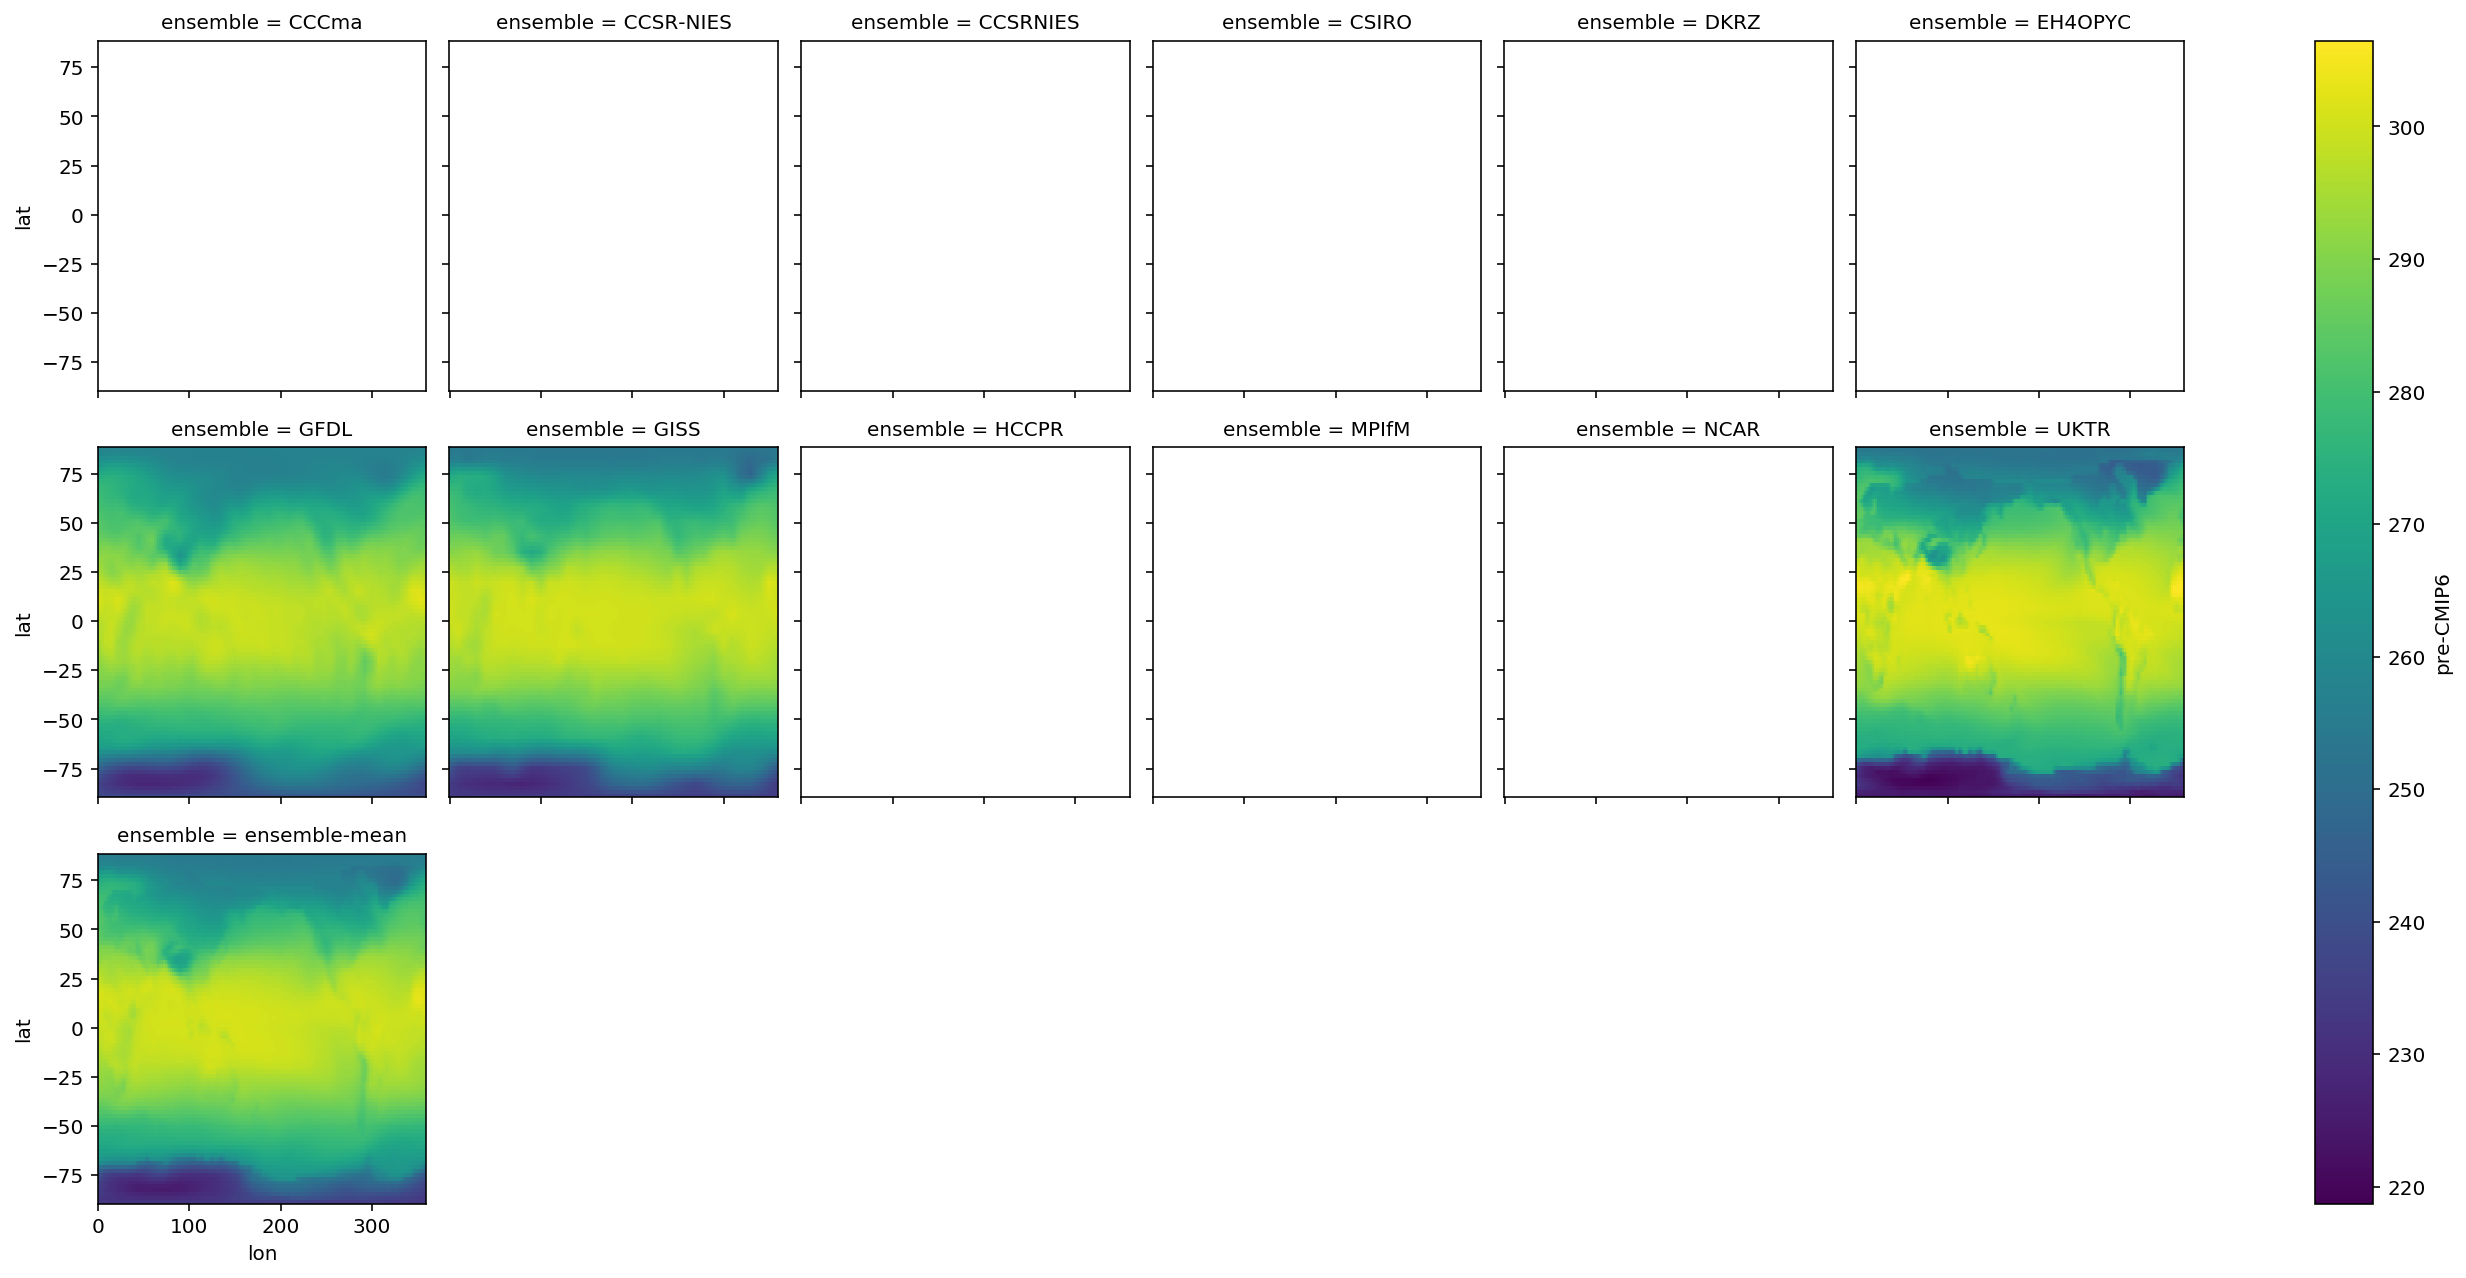

<Figure size 432x288 with 0 Axes>

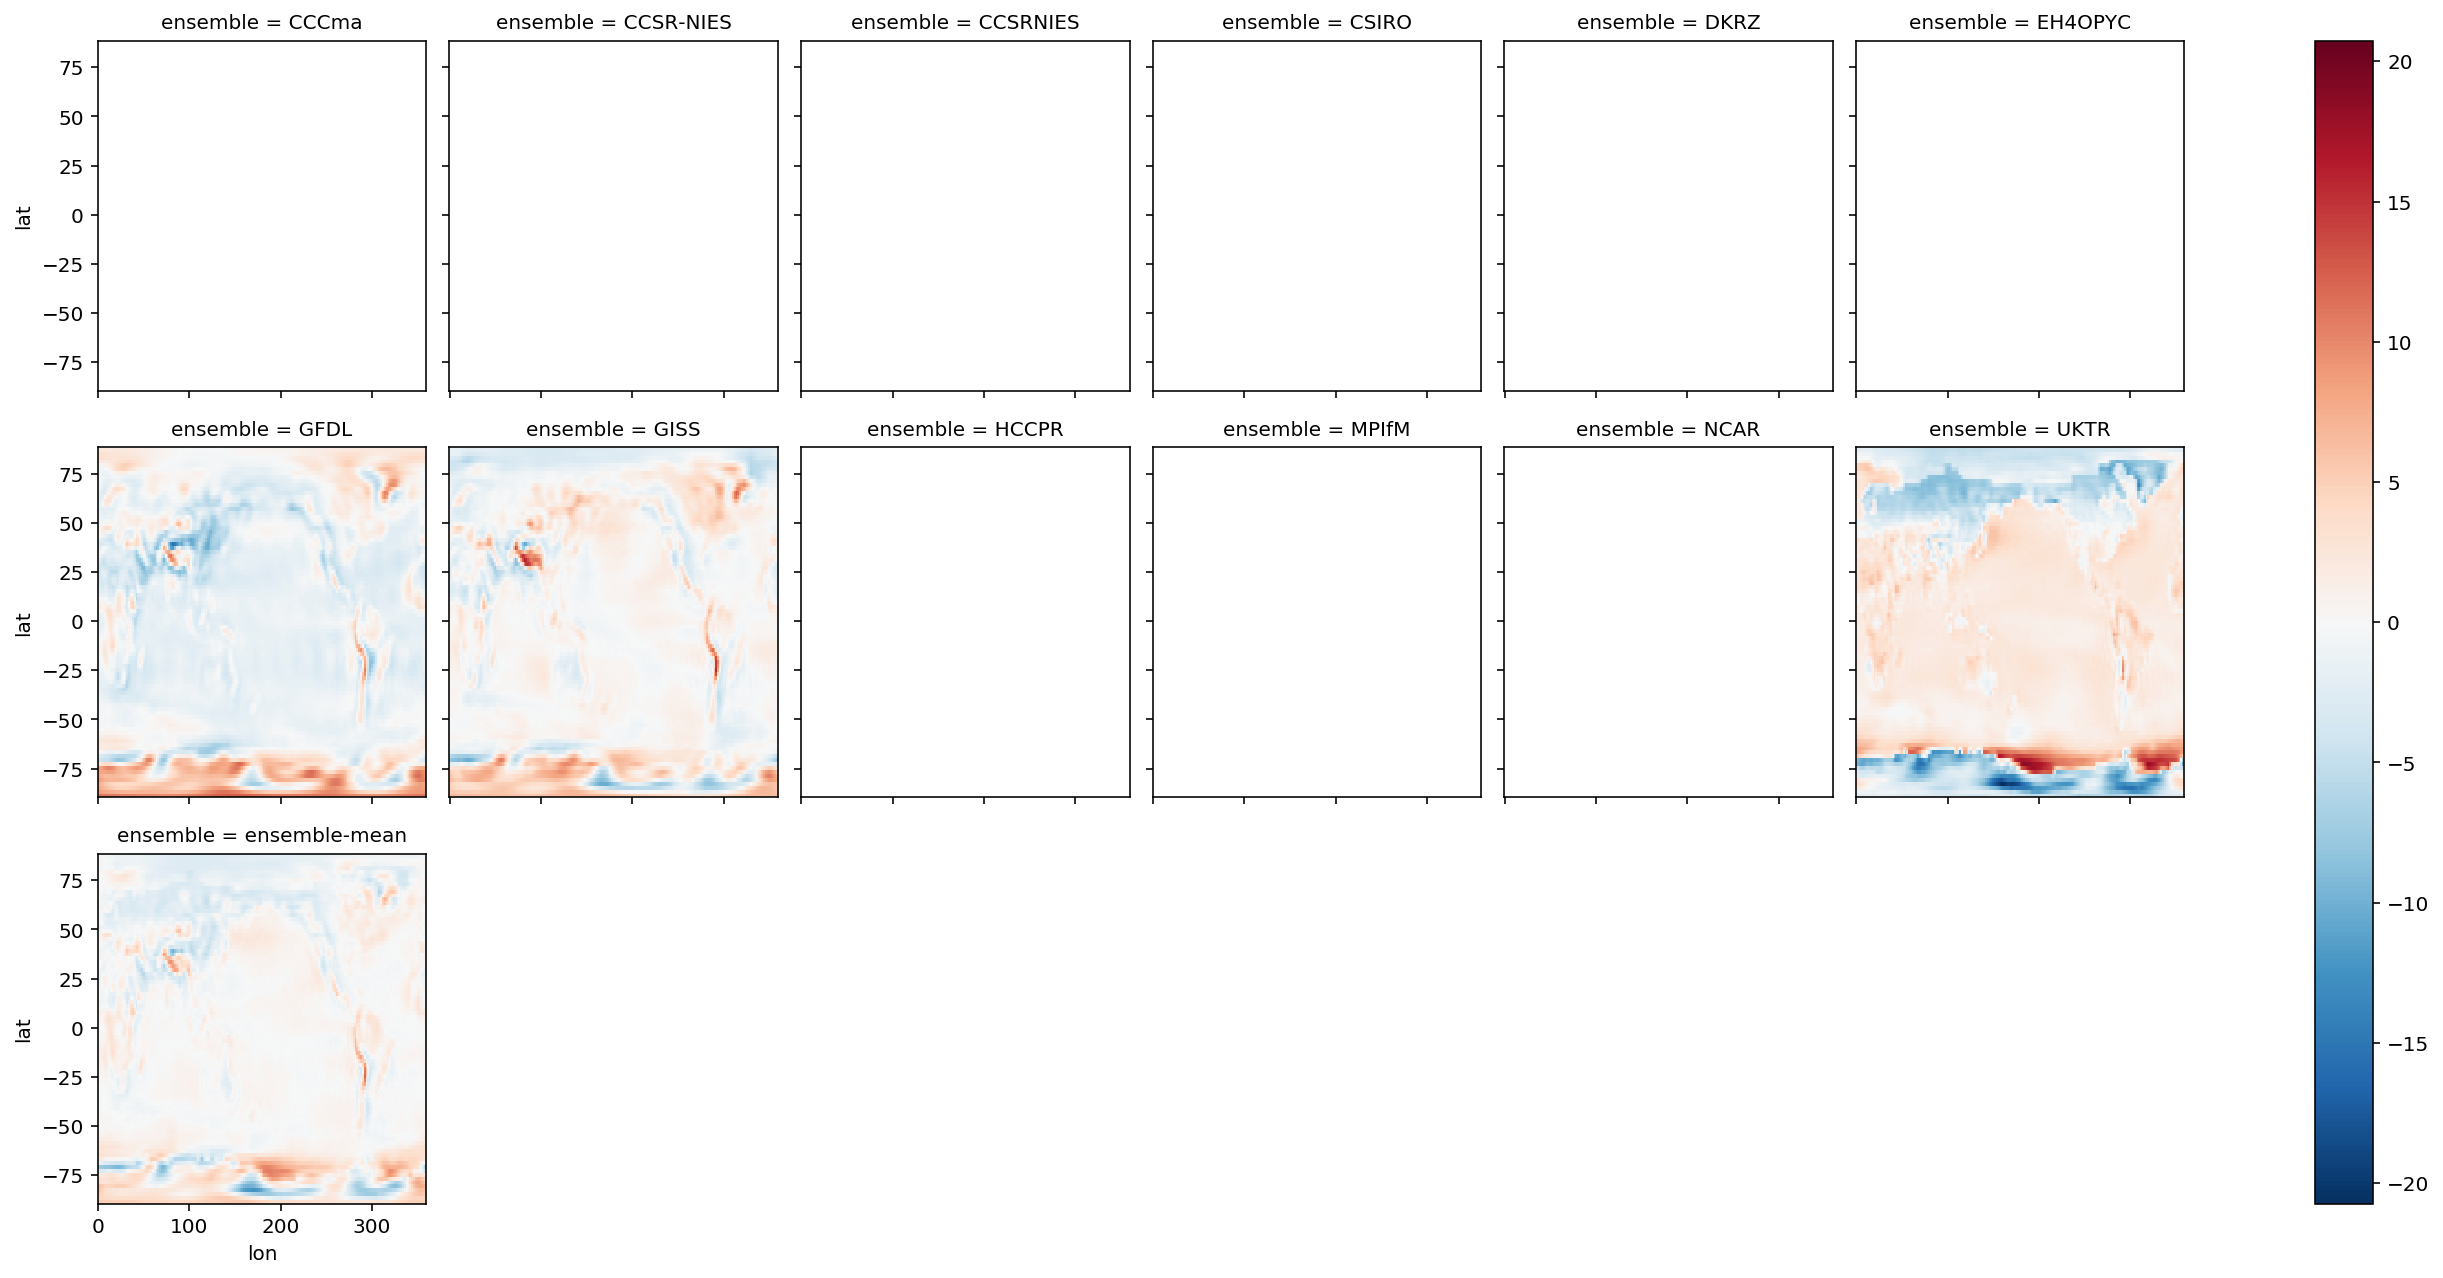

<Figure size 432x288 with 0 Axes>

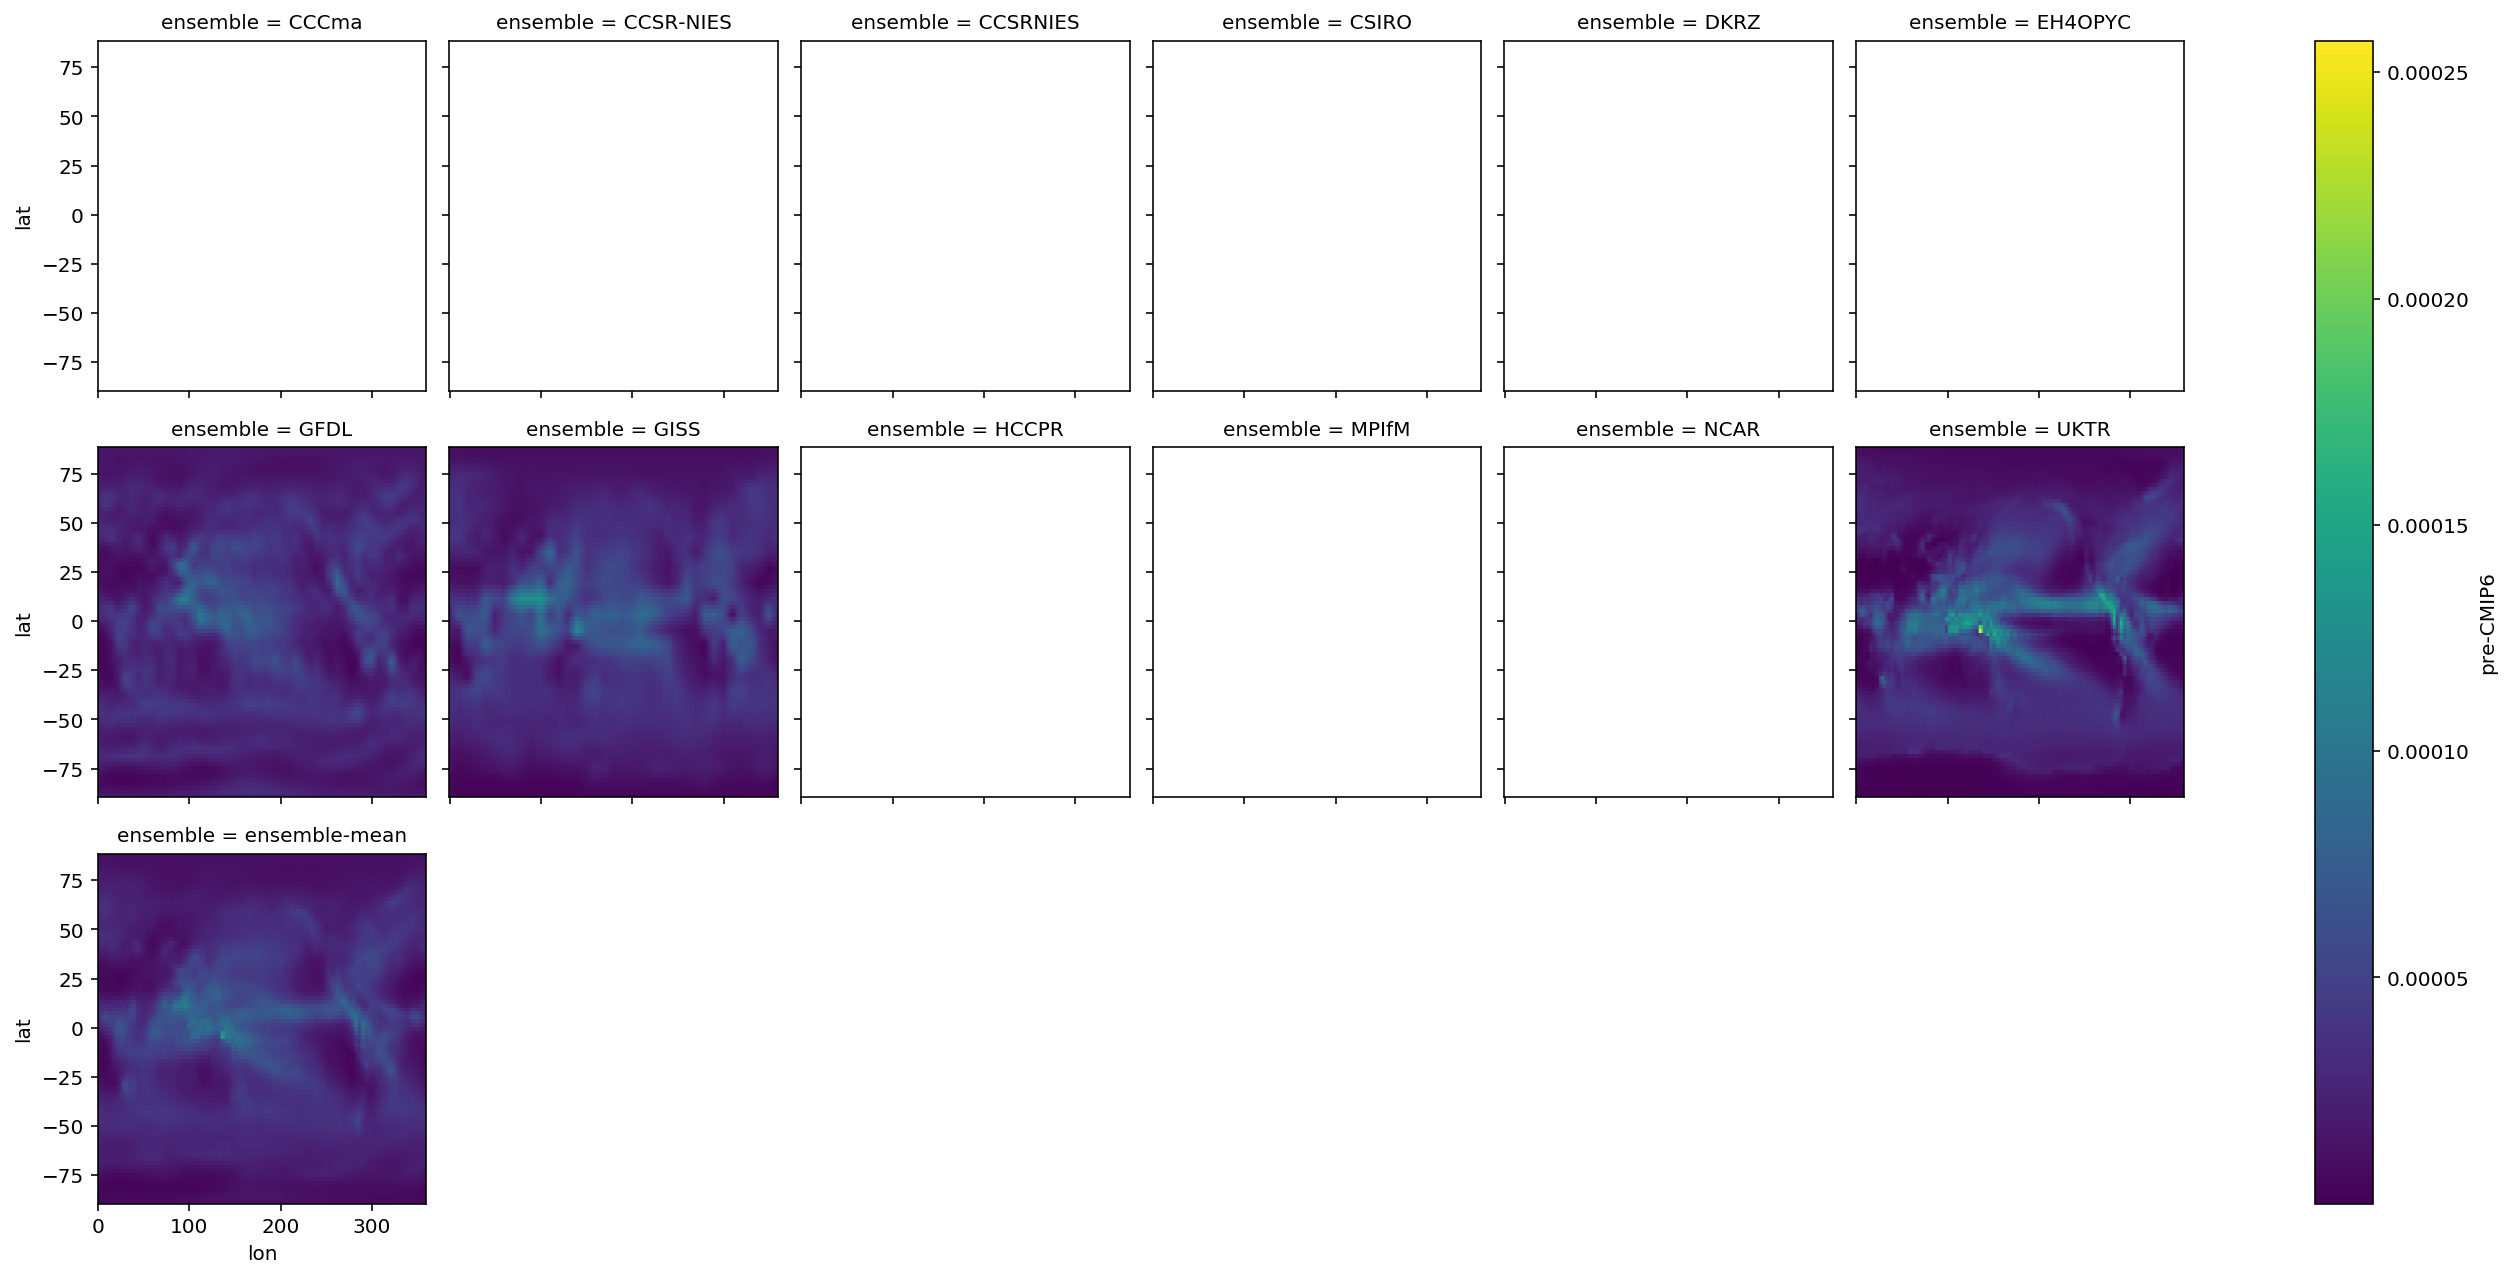

<Figure size 432x288 with 0 Axes>

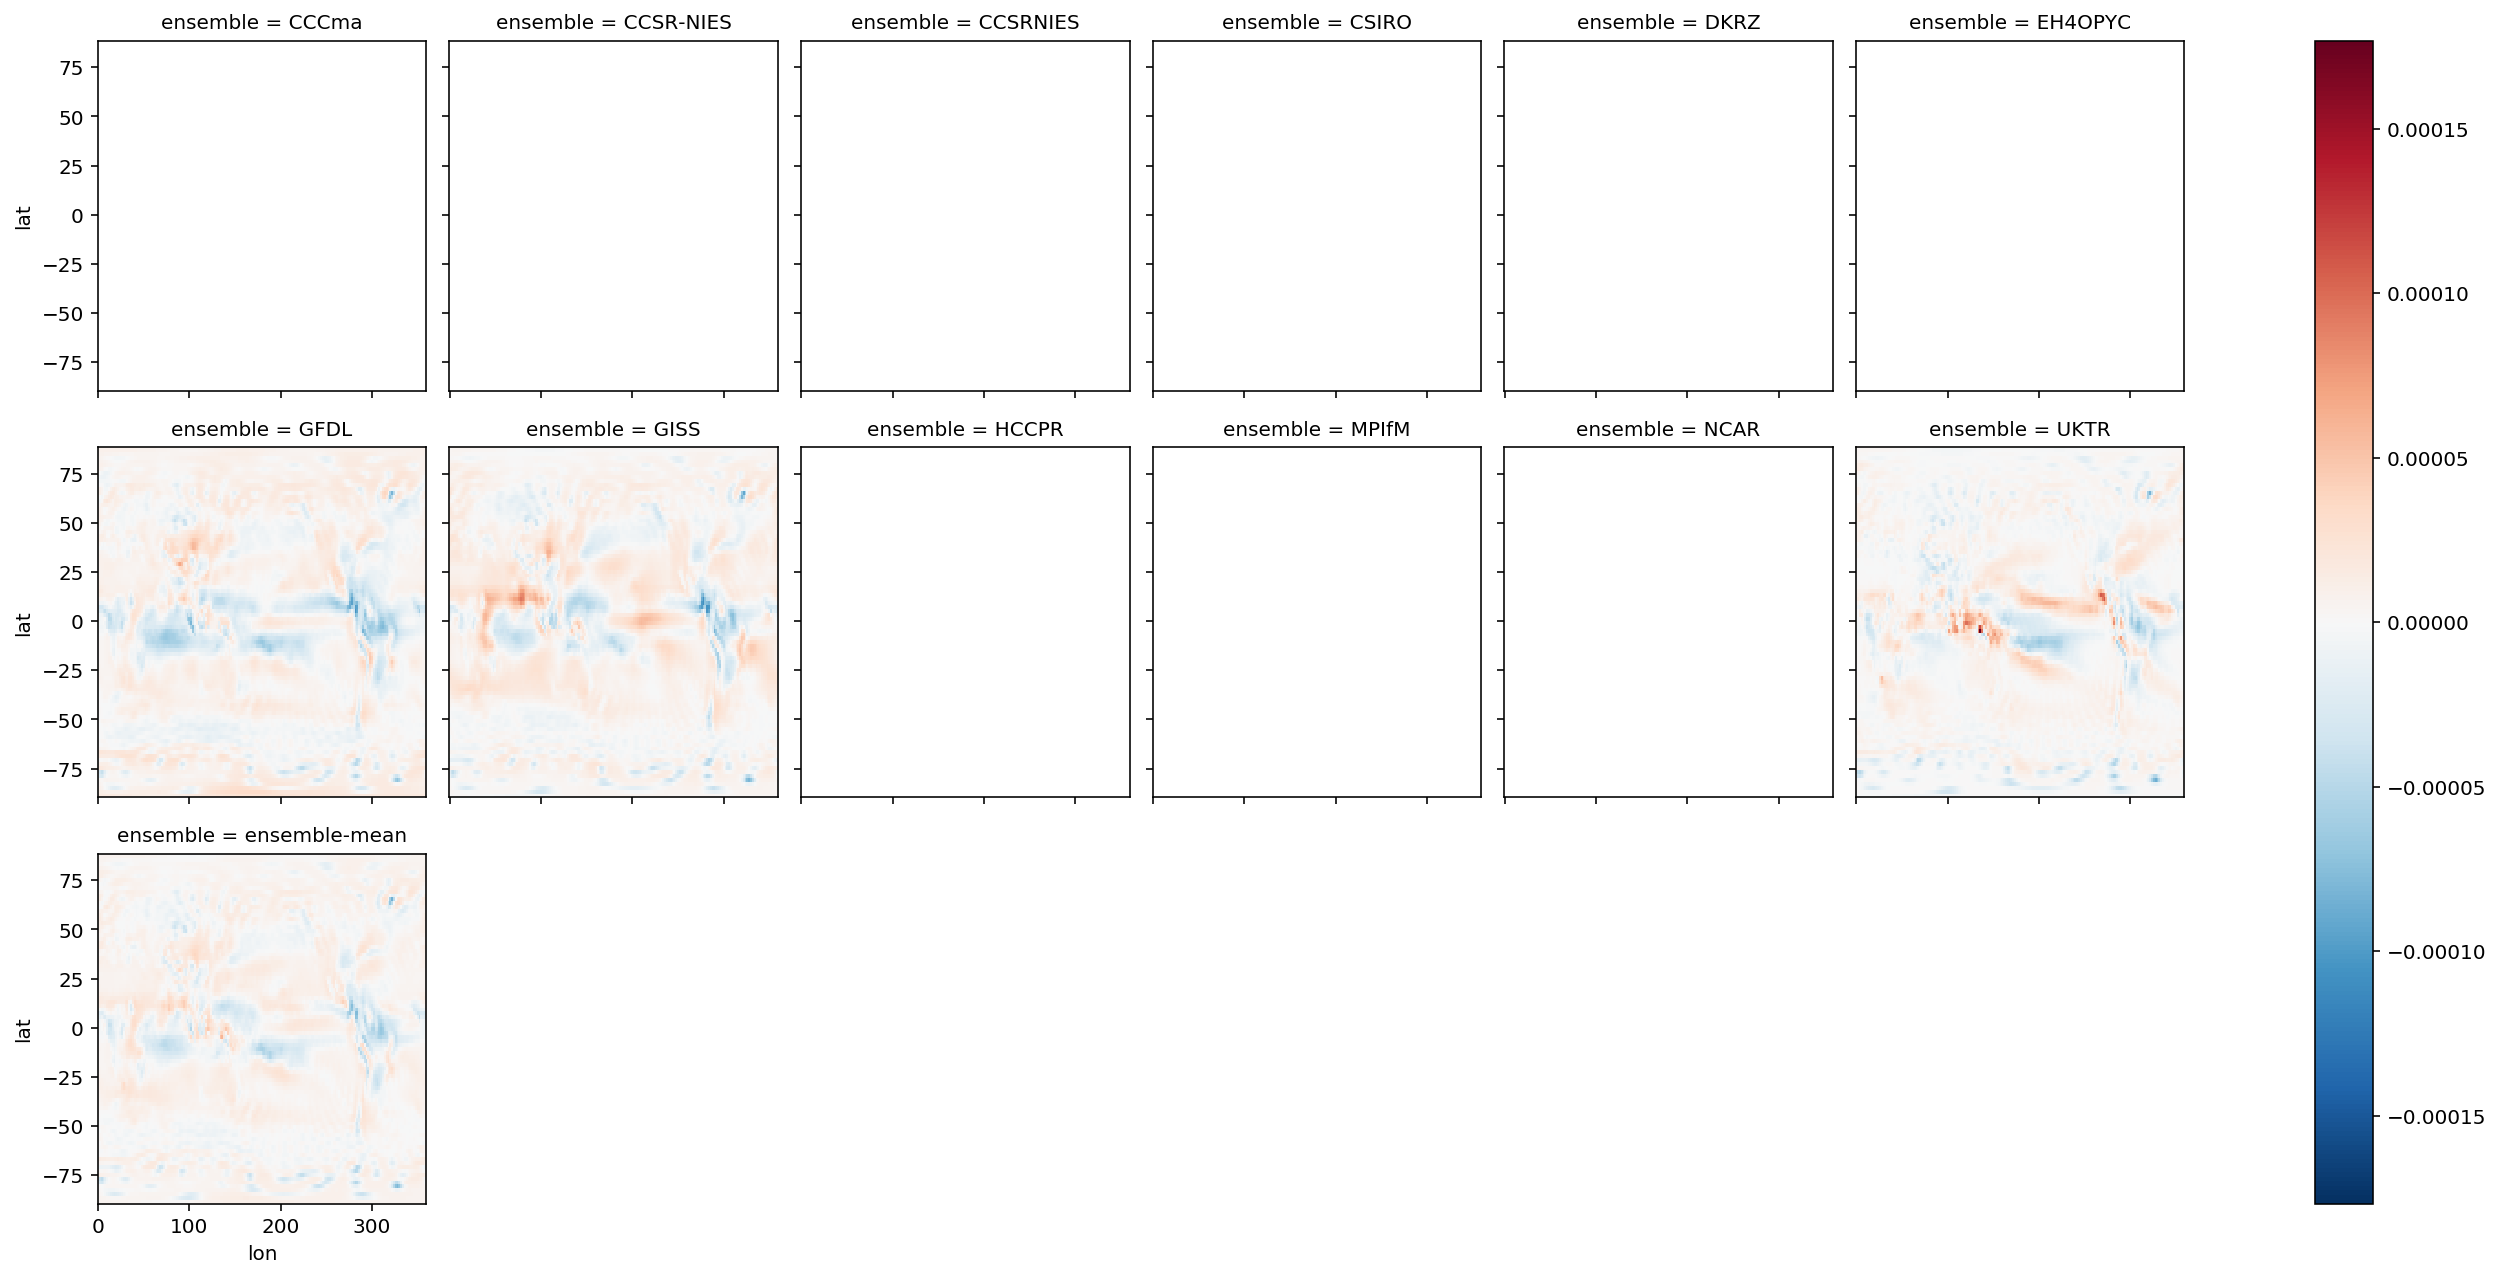

<Figure size 432x288 with 0 Axes>

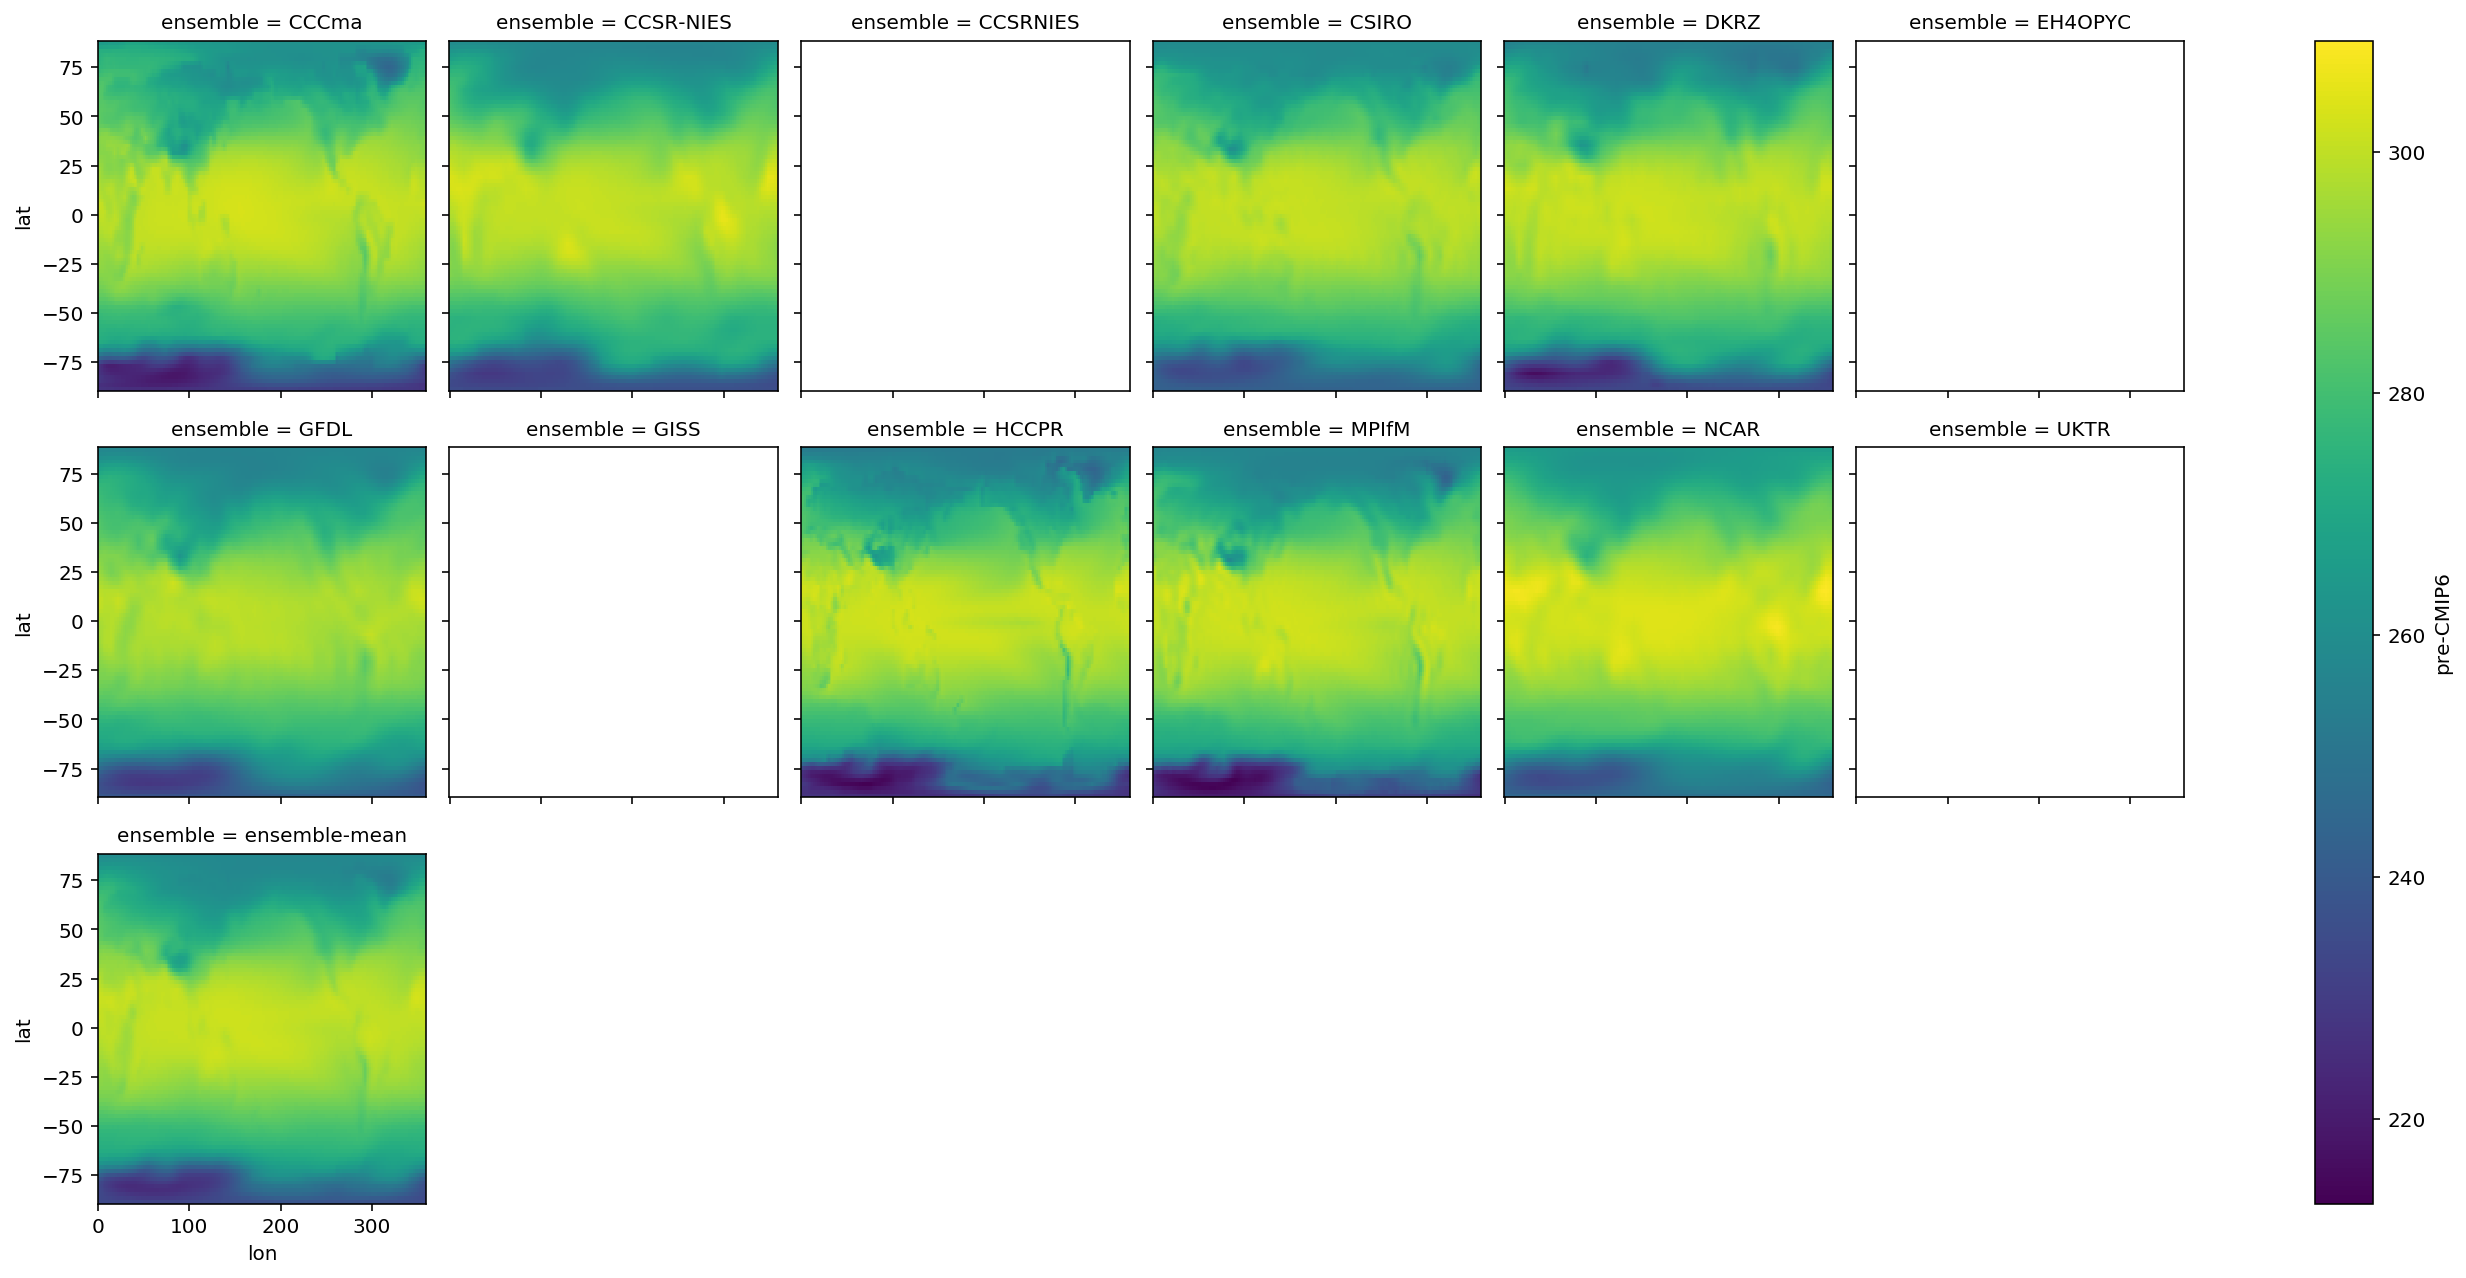

<Figure size 432x288 with 0 Axes>

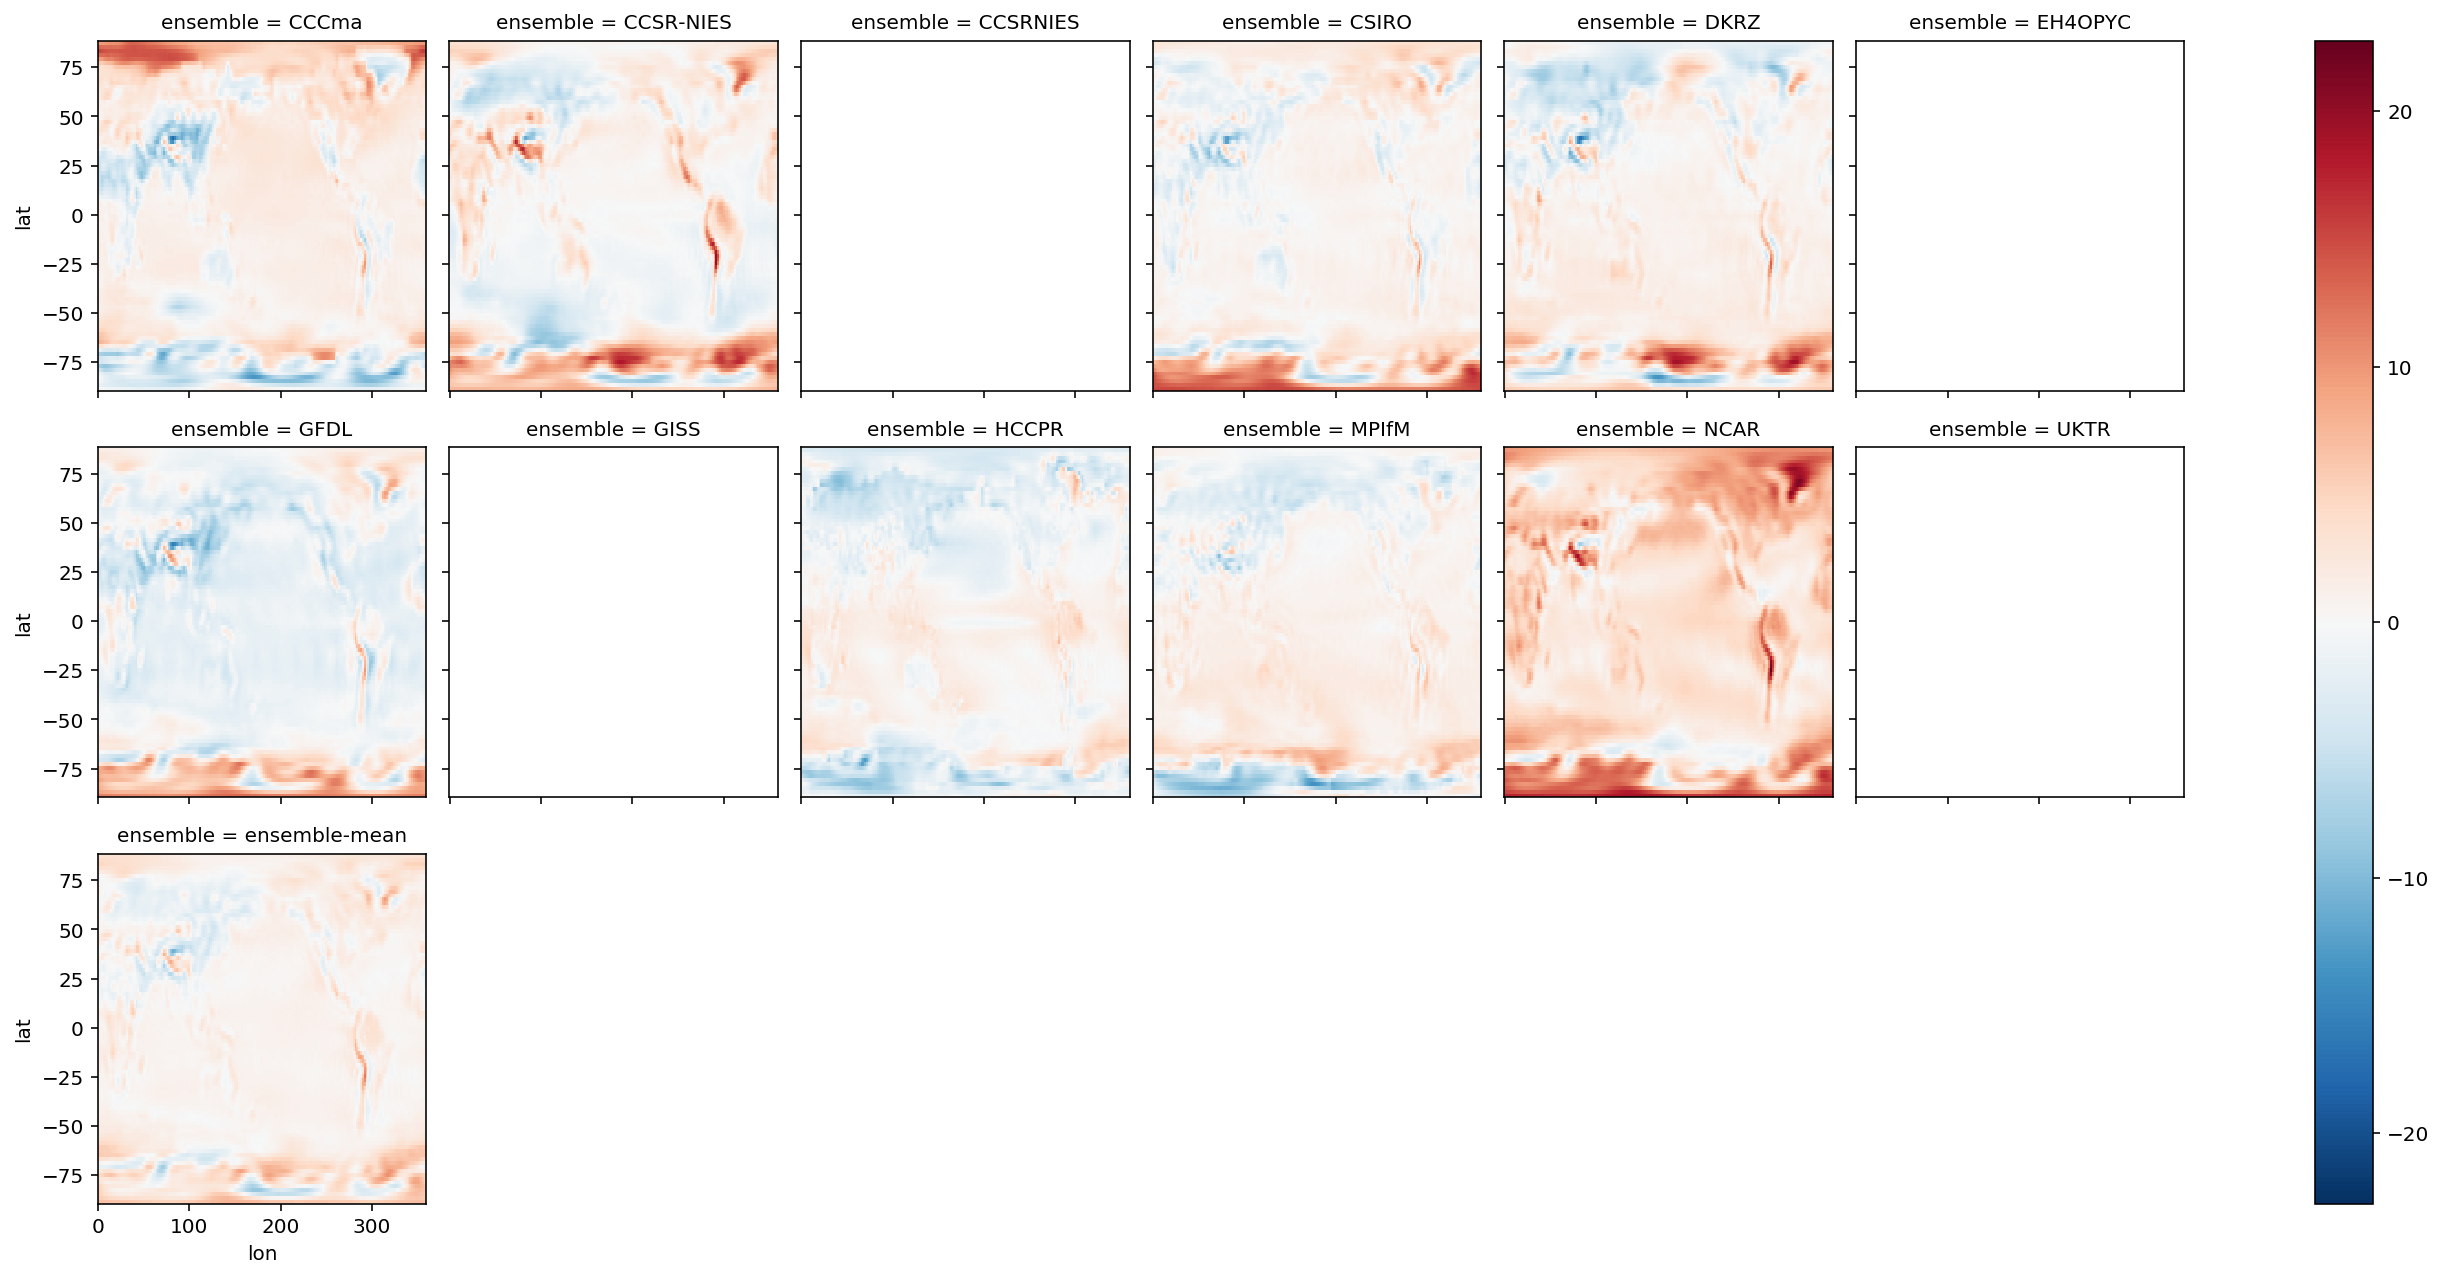

<Figure size 432x288 with 0 Axes>

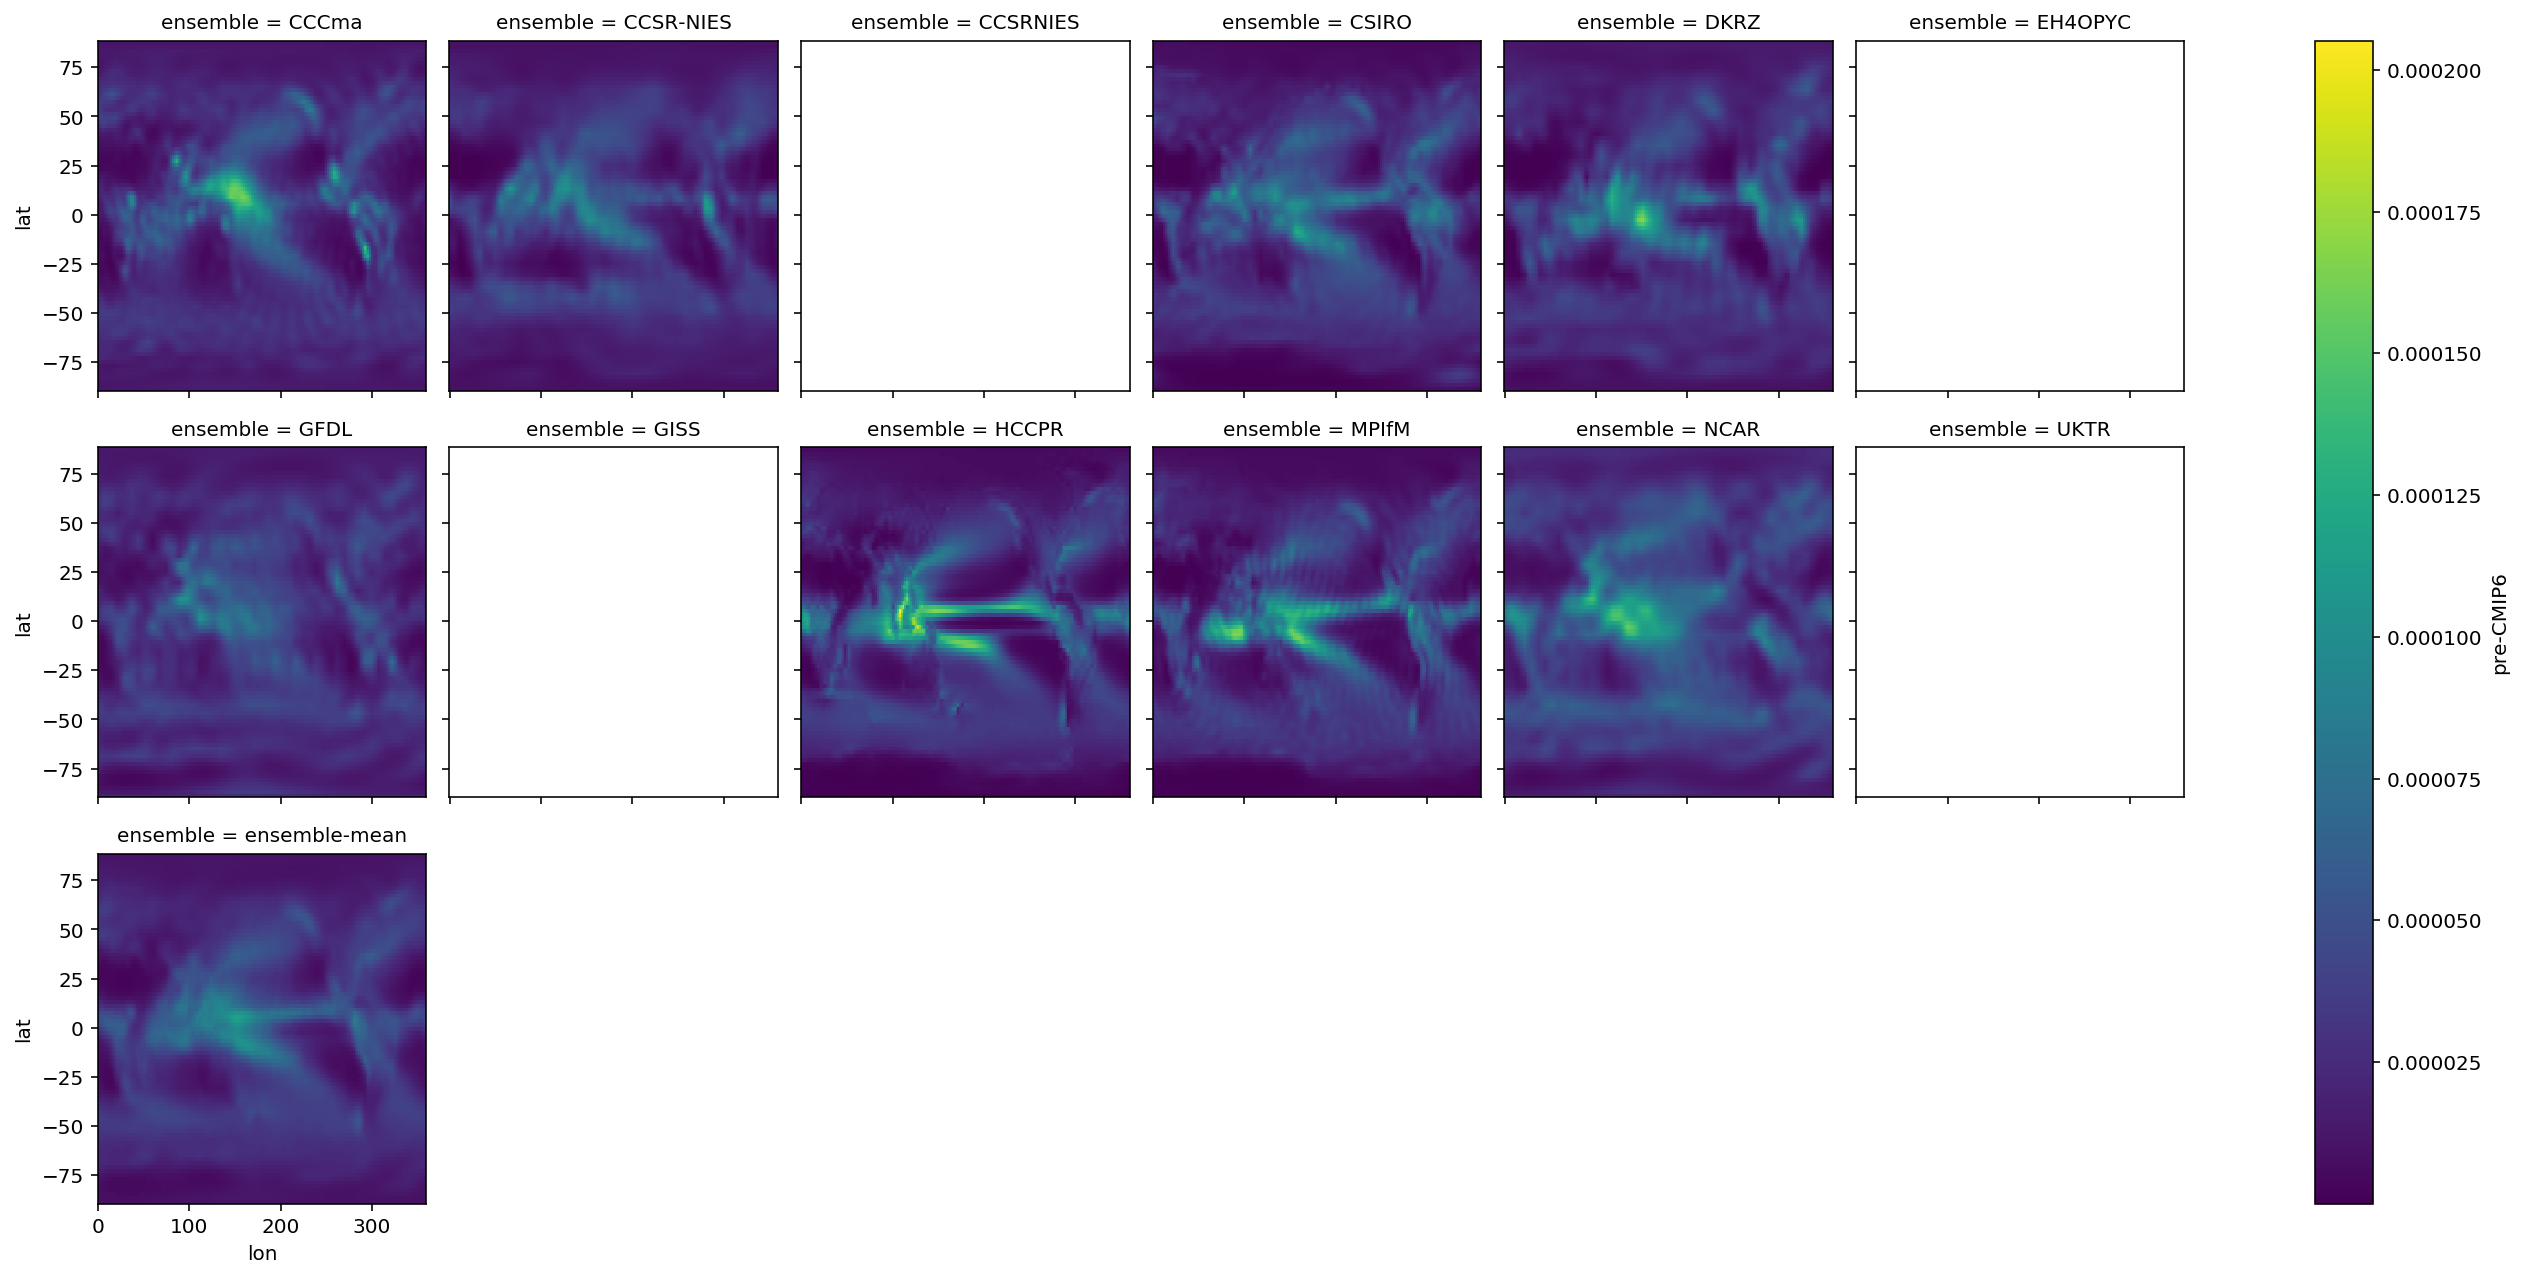

<Figure size 432x288 with 0 Axes>

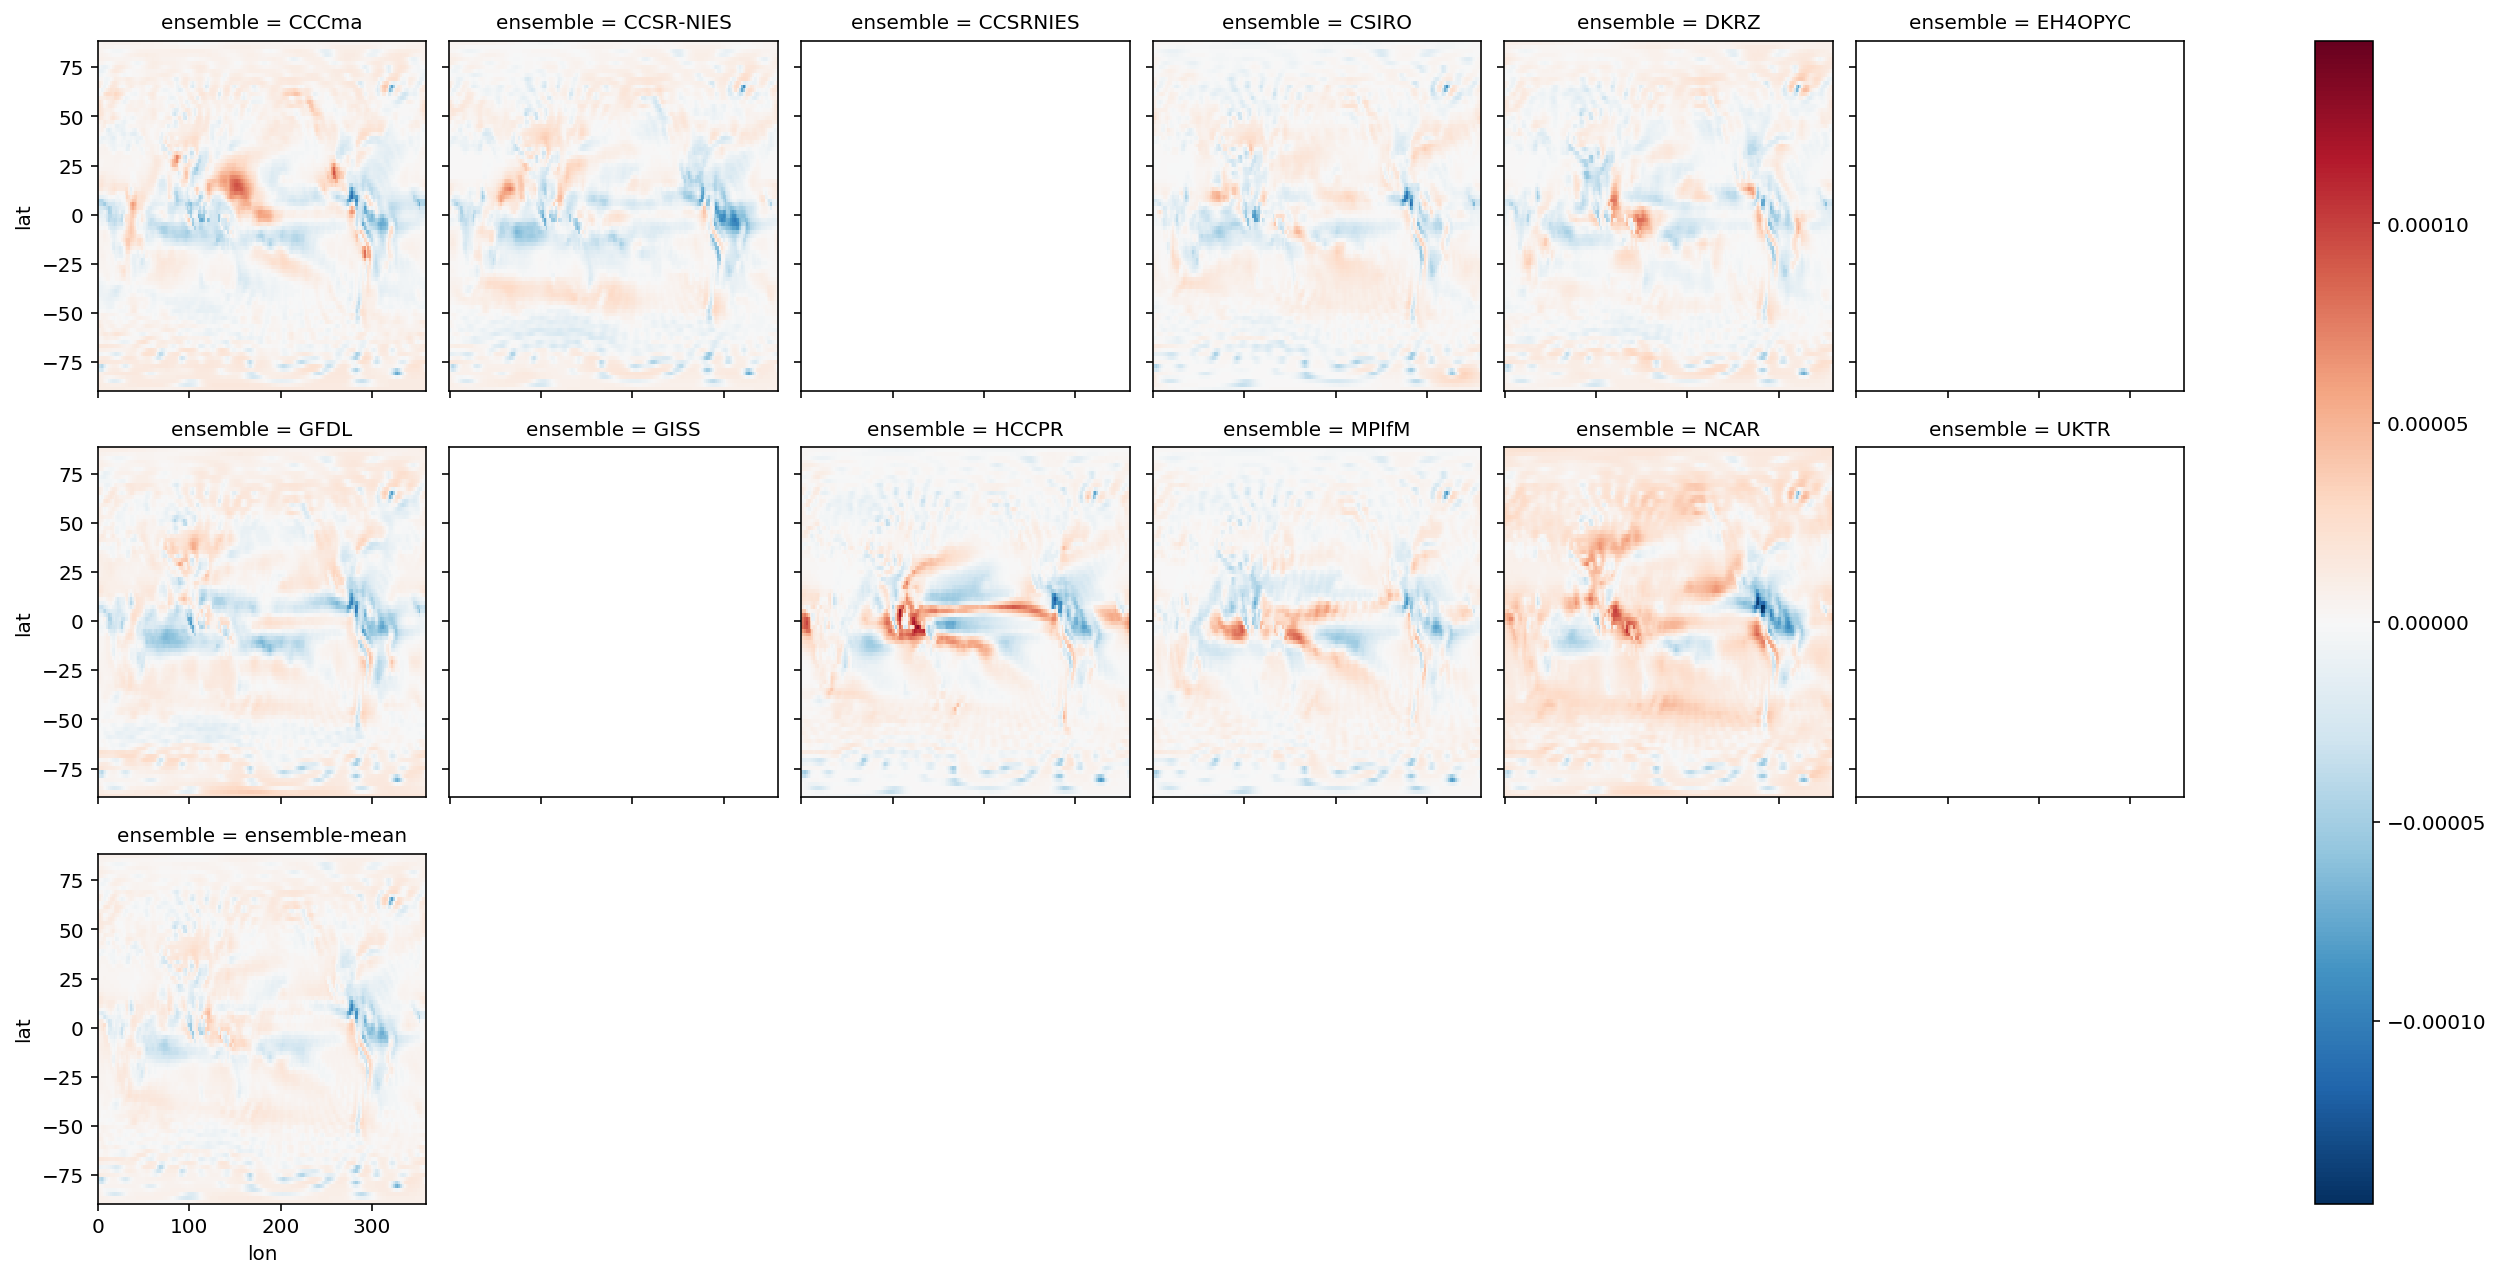

<Figure size 432x288 with 0 Axes>

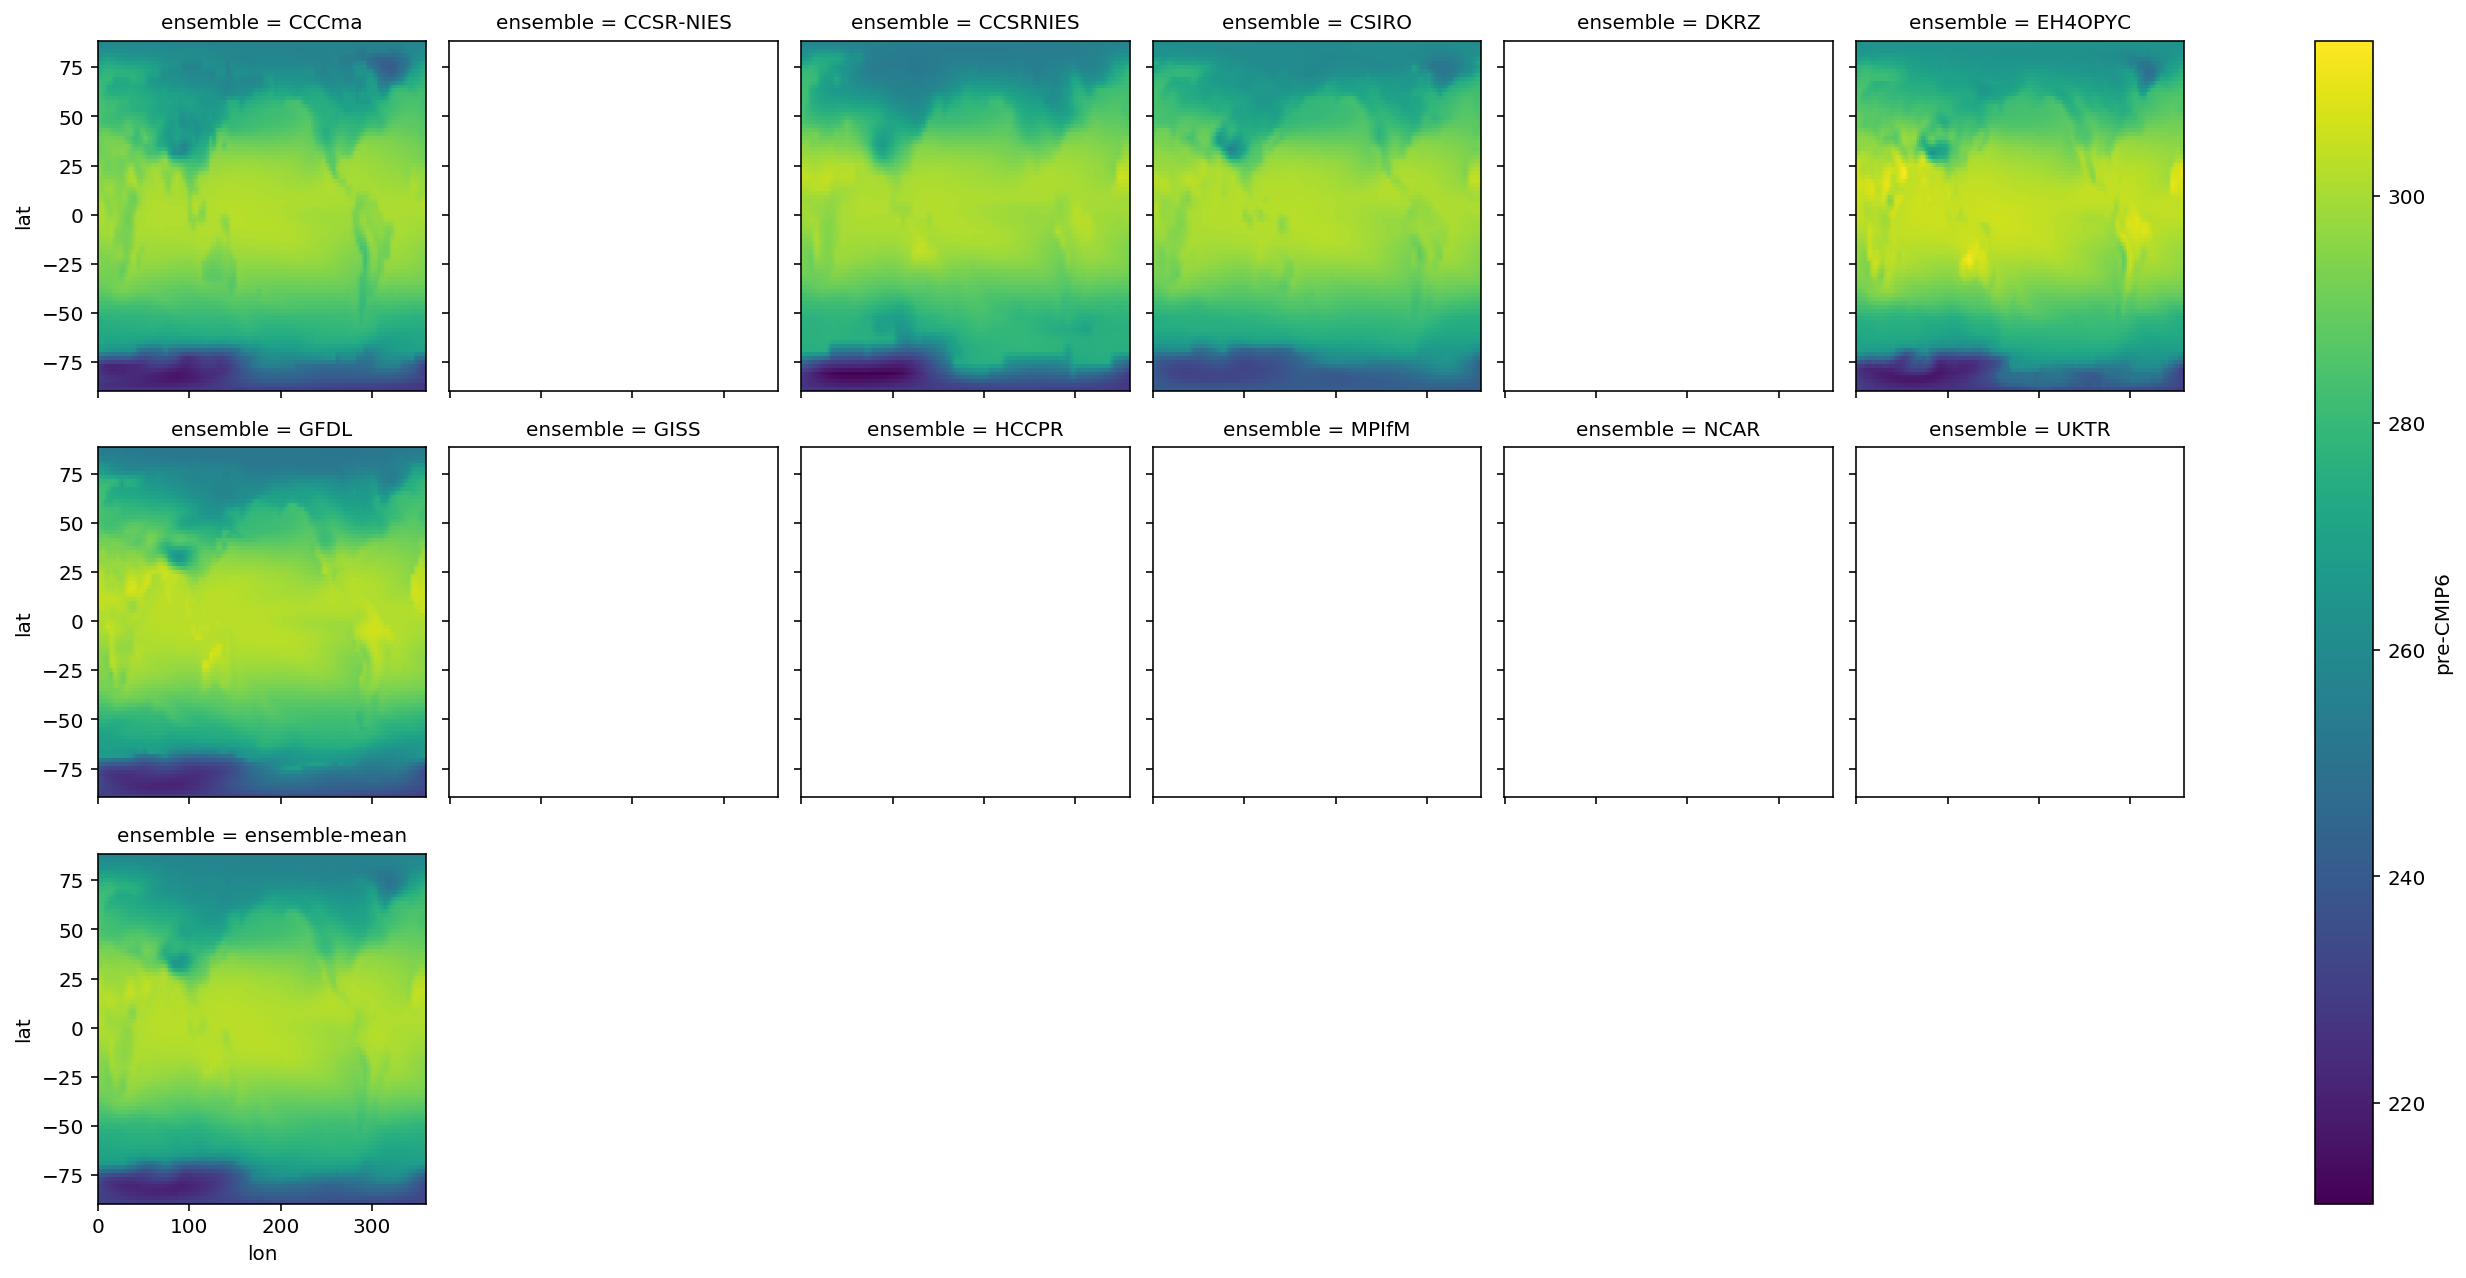

<Figure size 432x288 with 0 Axes>

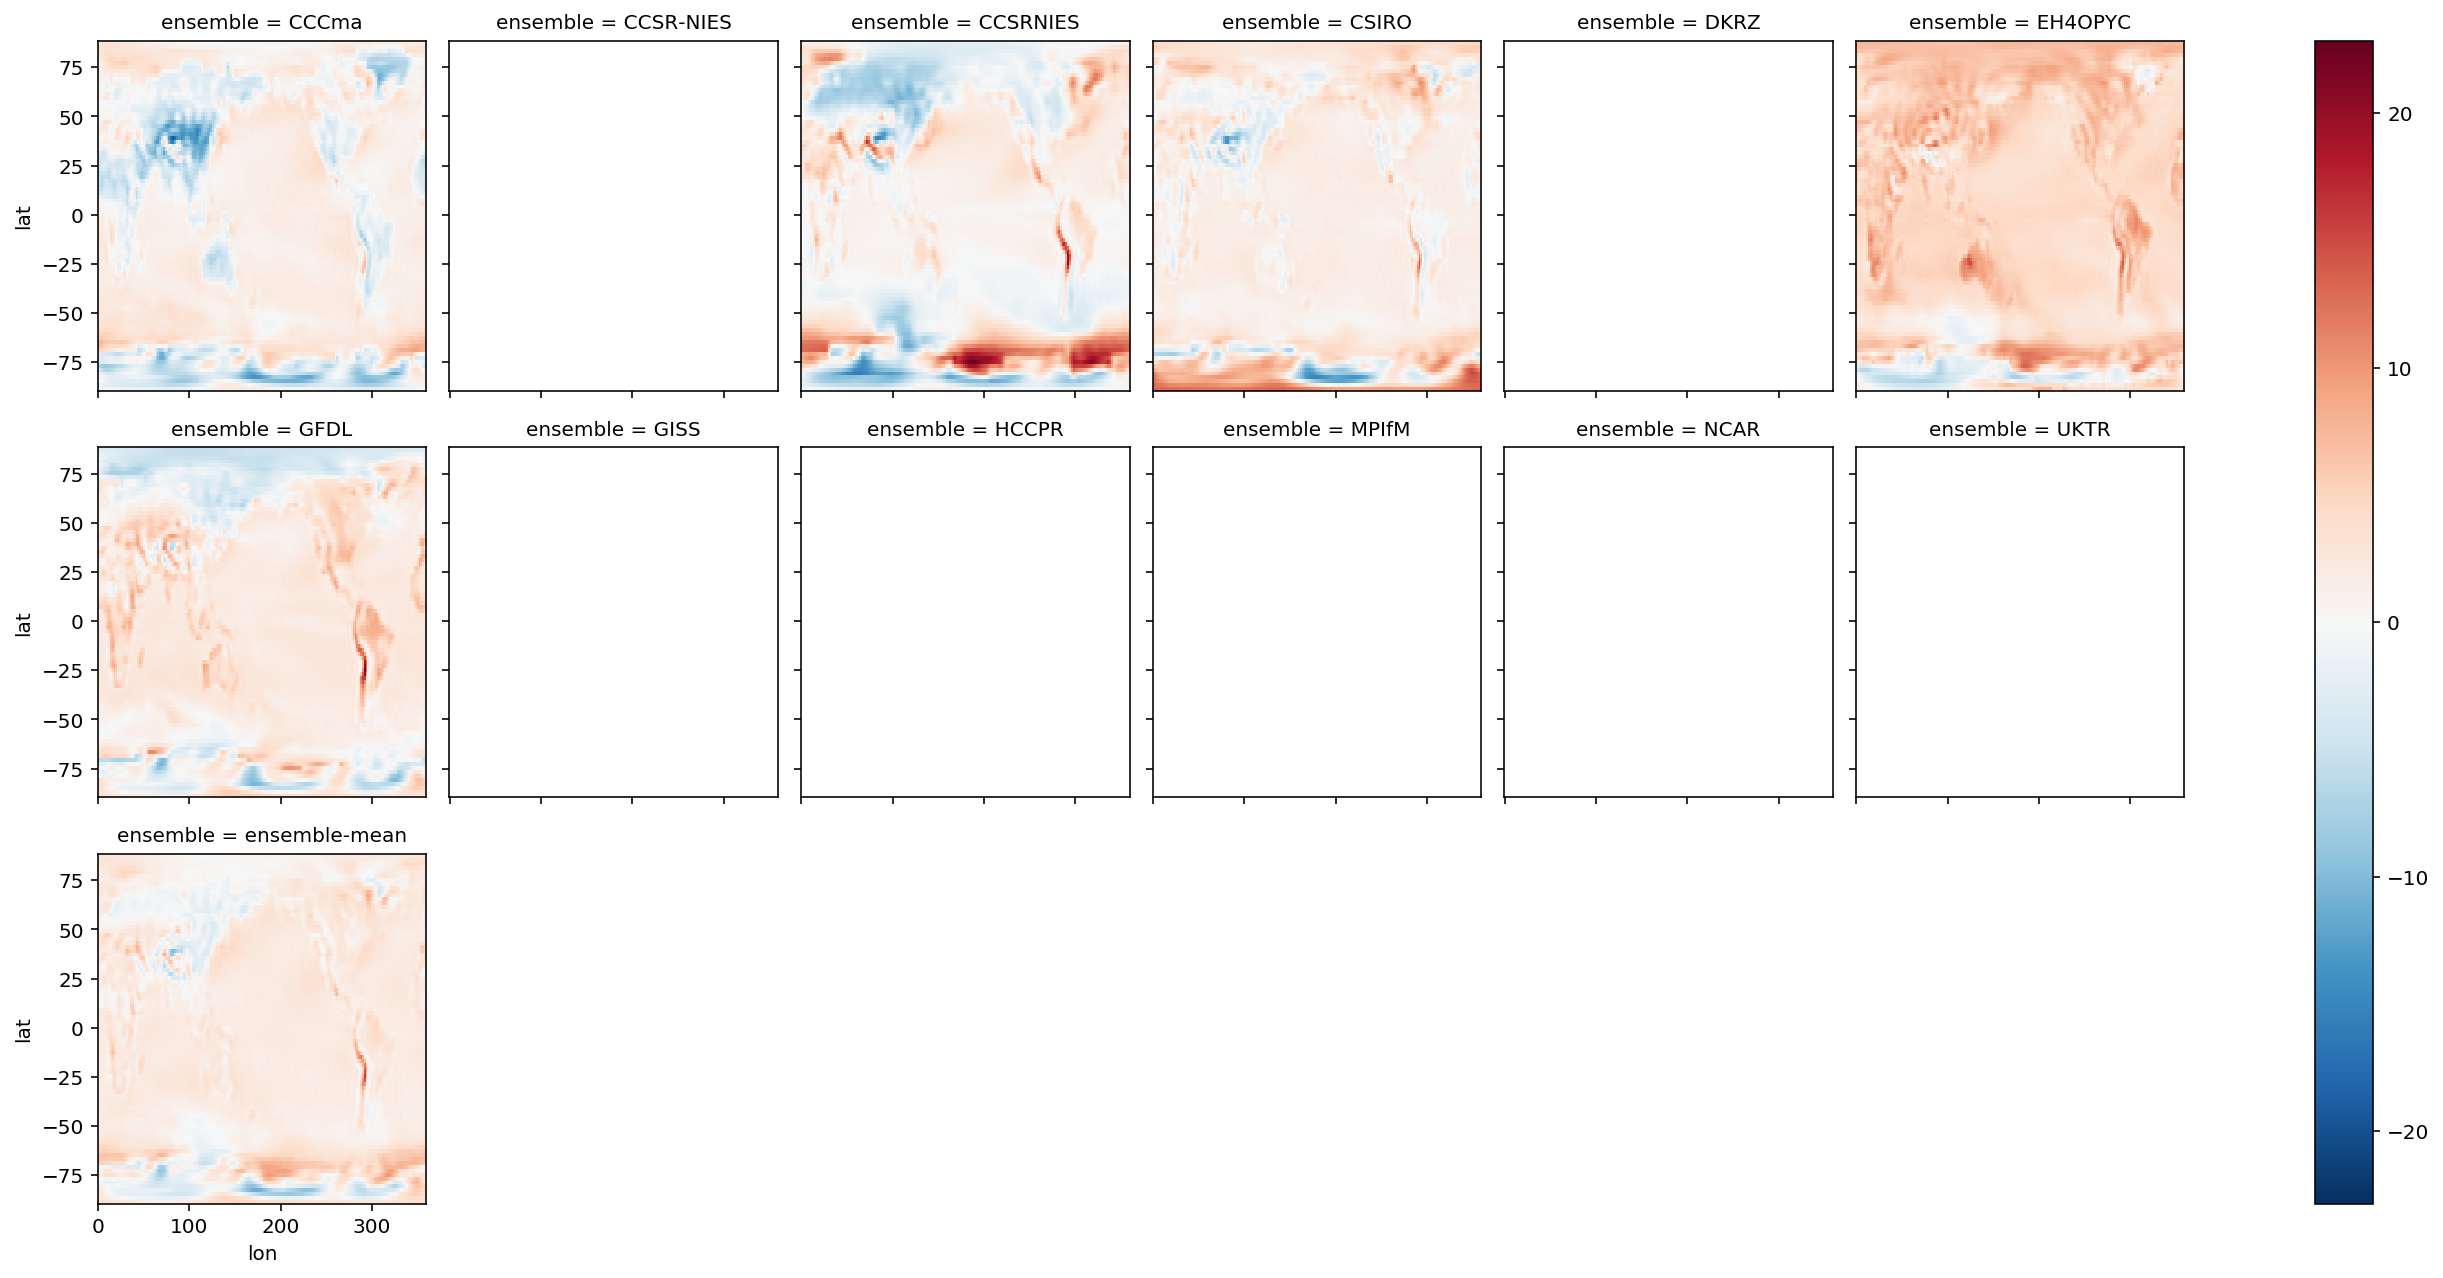

<Figure size 432x288 with 0 Axes>

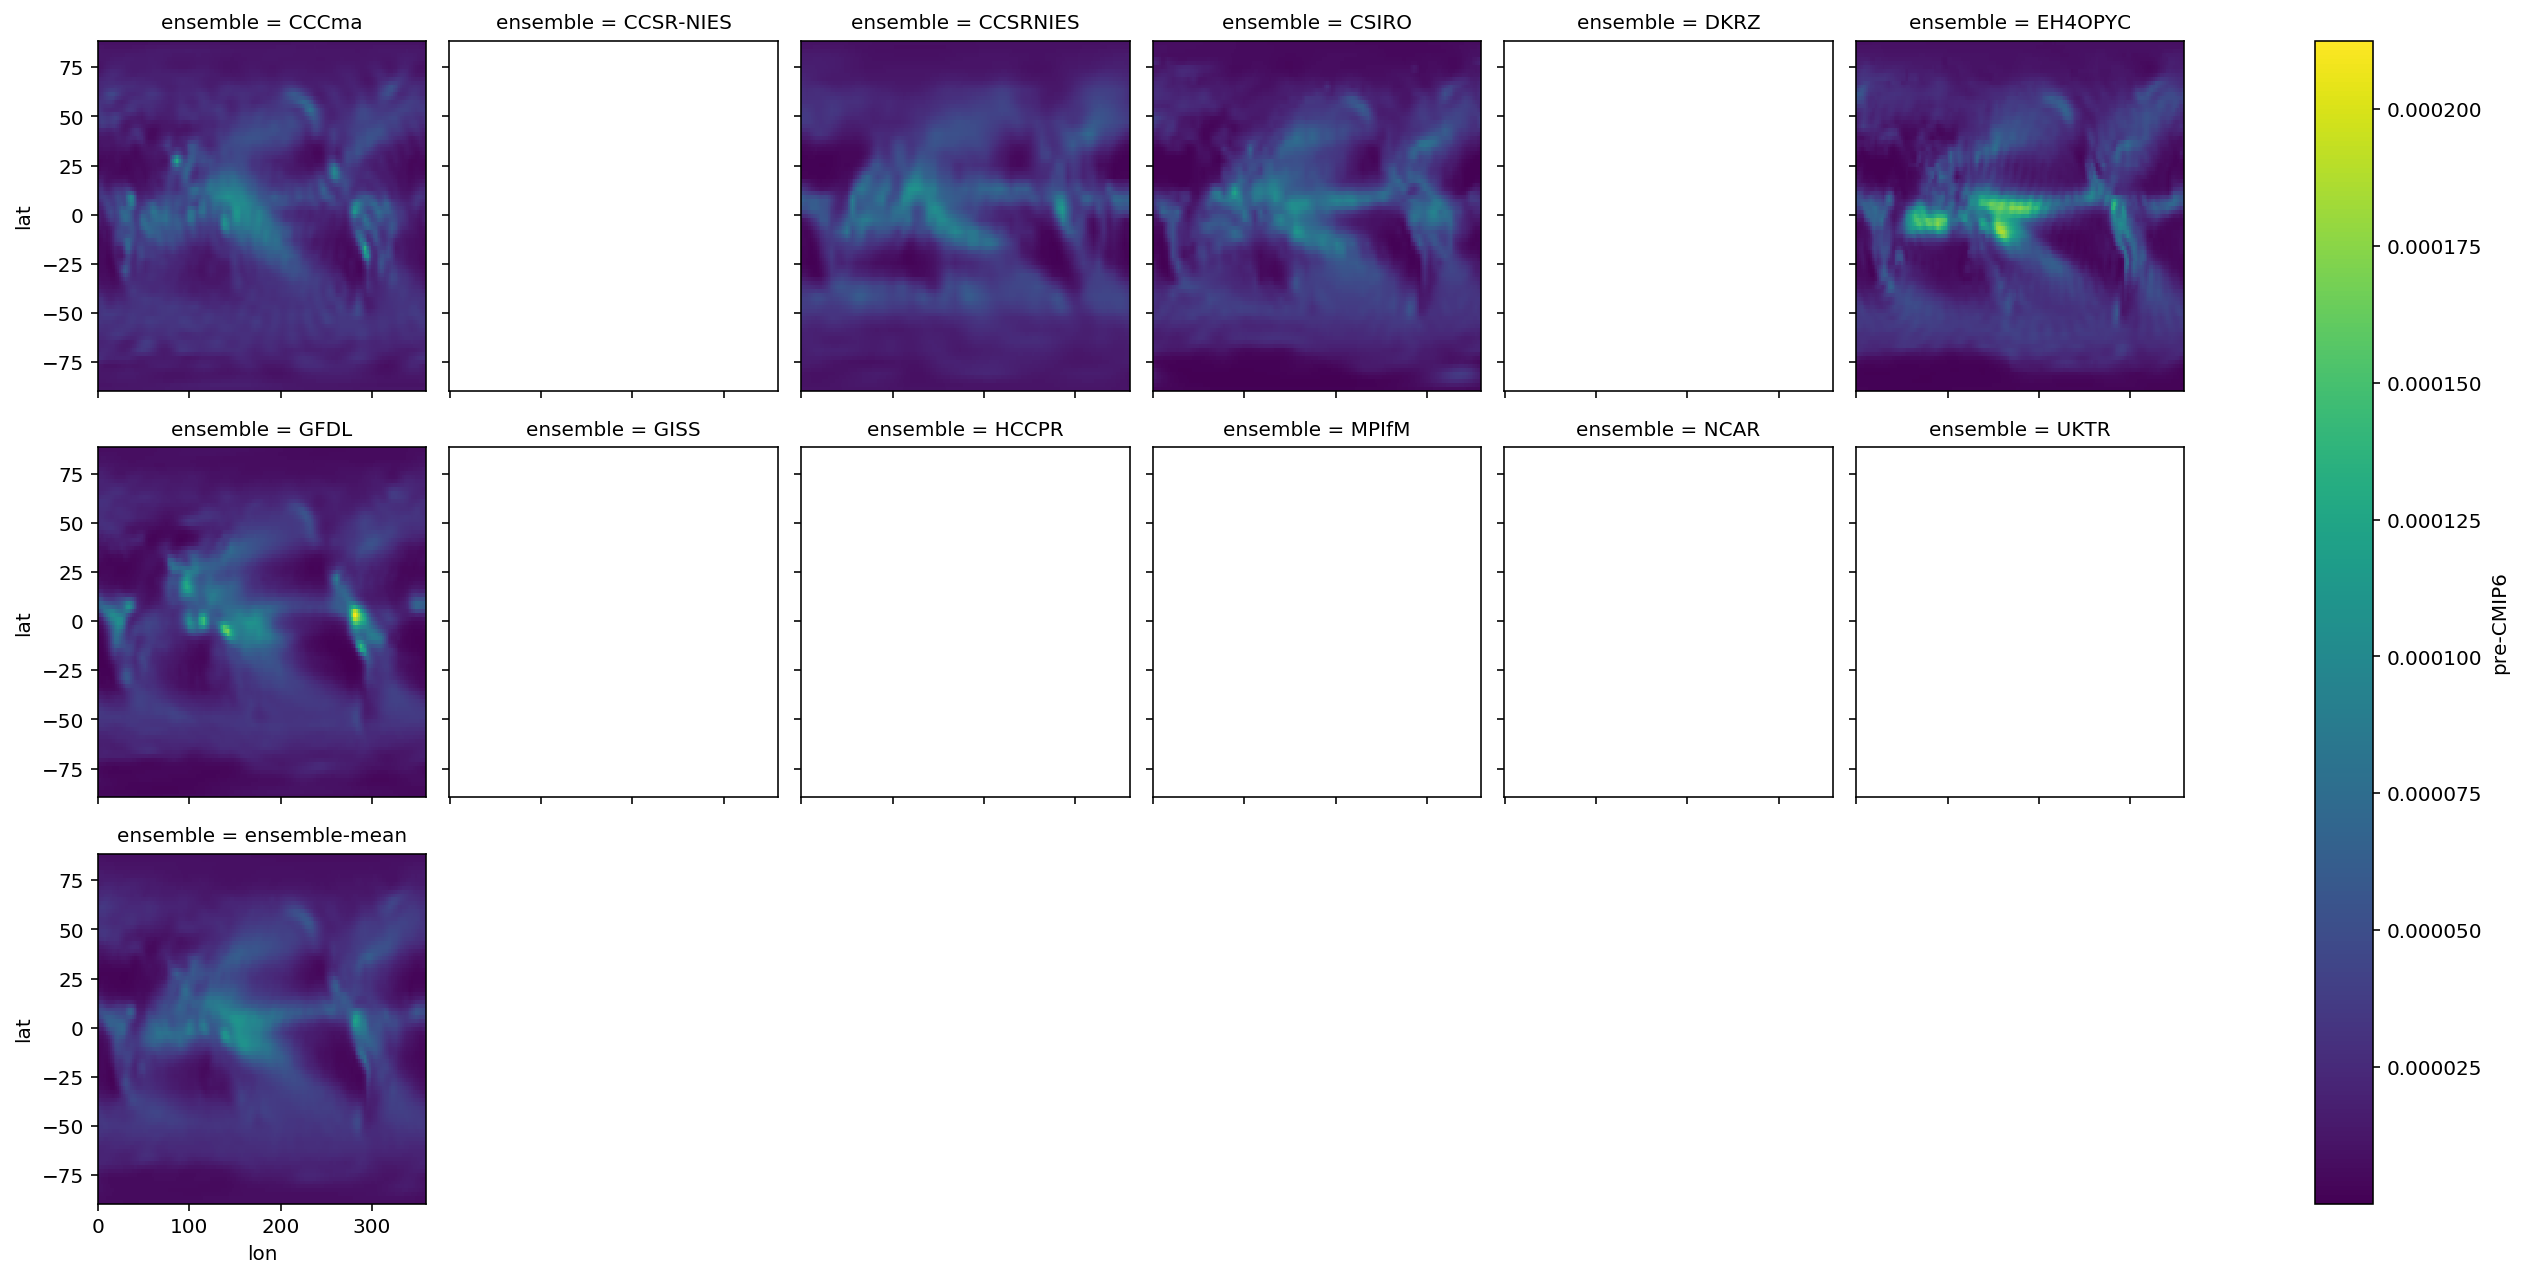

<Figure size 432x288 with 0 Axes>

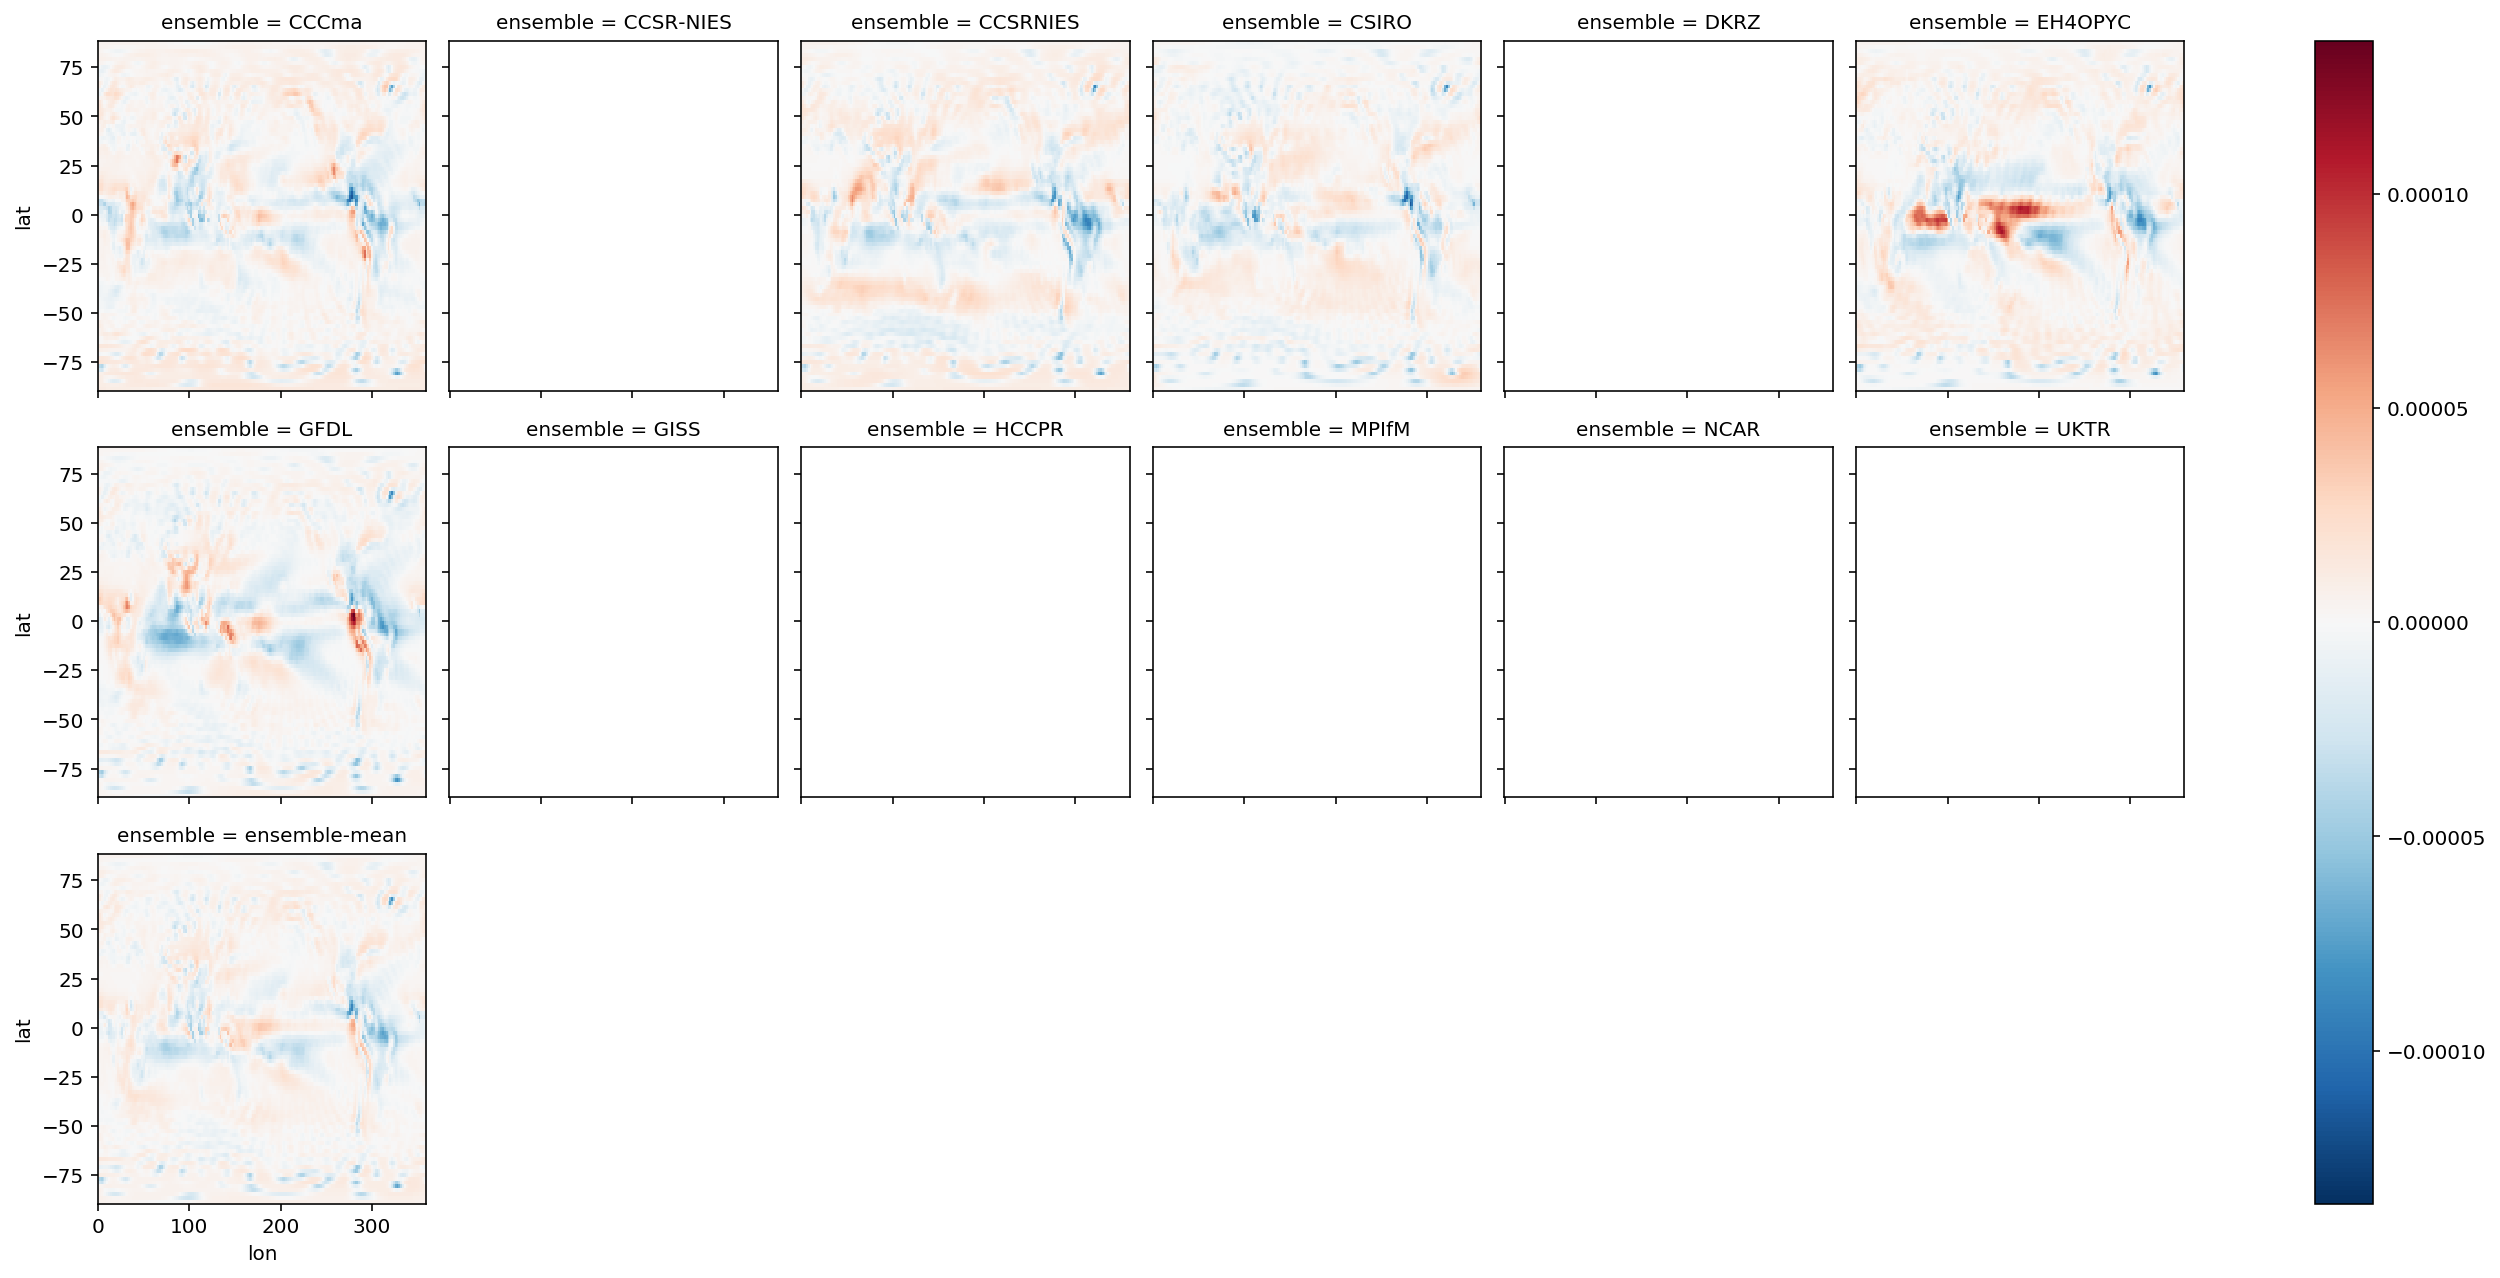

In [54]:
for mip_id in mip_ids:
    for varname in varnames:
        # Plot mean state
        plt.figure()
        q = ens.sel(var=varname, mip=mip_id).plot(x='lon', y='lat', col='ensemble', col_wrap=6)

        # Plot anomalies with respect to observations (temporarily, actually multi-model mean)
        plt.figure()
        q = (ens-ncep).sel(var=varname, mip=mip_id).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
        # How to change color bar limits?

In [55]:
def carpet_plot(da):
    coords = list(da.coords)
    q = plt.pcolormesh(da.values, cmap='RdYlBu_r')
    plt.xticks(np.arange(da.coords[coords[0]].size)+0.5, list(da.coords[coords[0]].values))
    plt.yticks(np.arange(da.coords[coords[1]].size)+0.5, list(da.coords[coords[1]].values), rotation=90.)
    plt.colorbar()
    plt.clim([0.5,1.5])
    return q

# Normalized Root-Mean-Square Error

In [56]:
rmse = xs.rmse(ncep, ens, ['lat', 'lon']).compute()
SAR_rmse_med = rmse.sel(mip='SAR').median(dim='ensemble').compute()


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


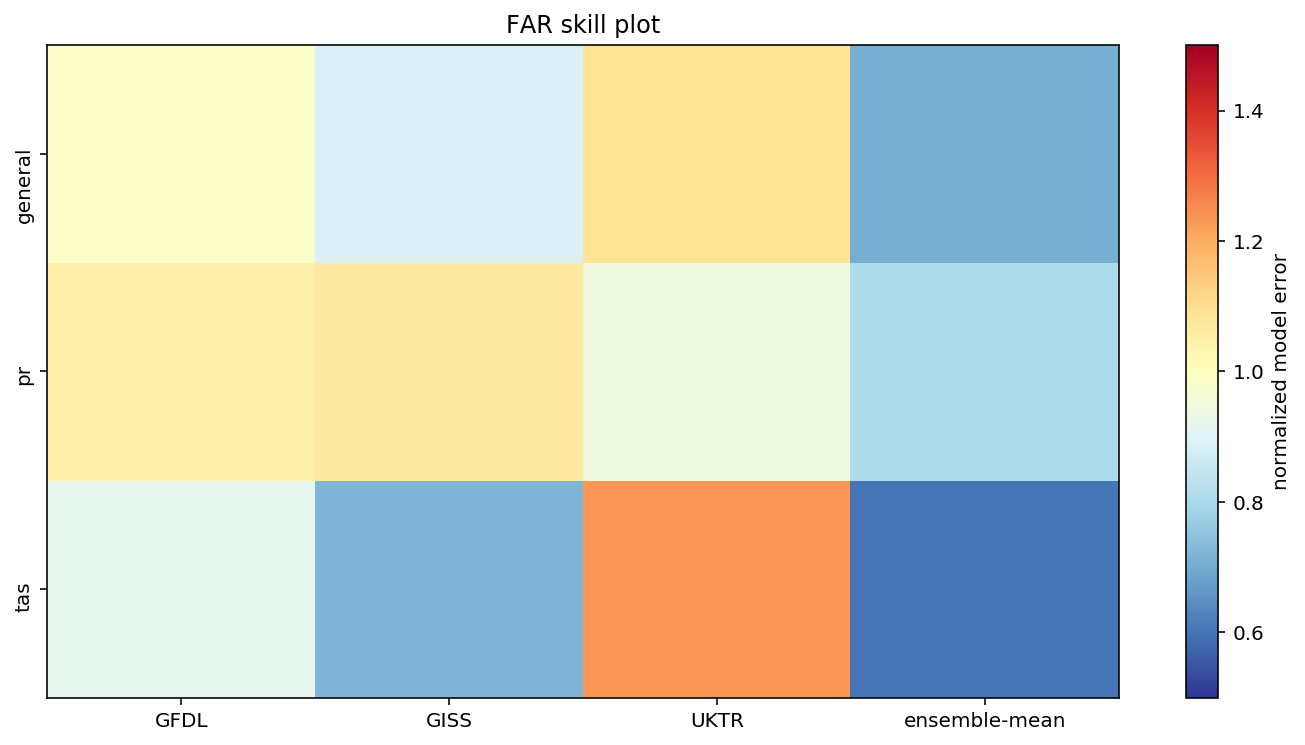

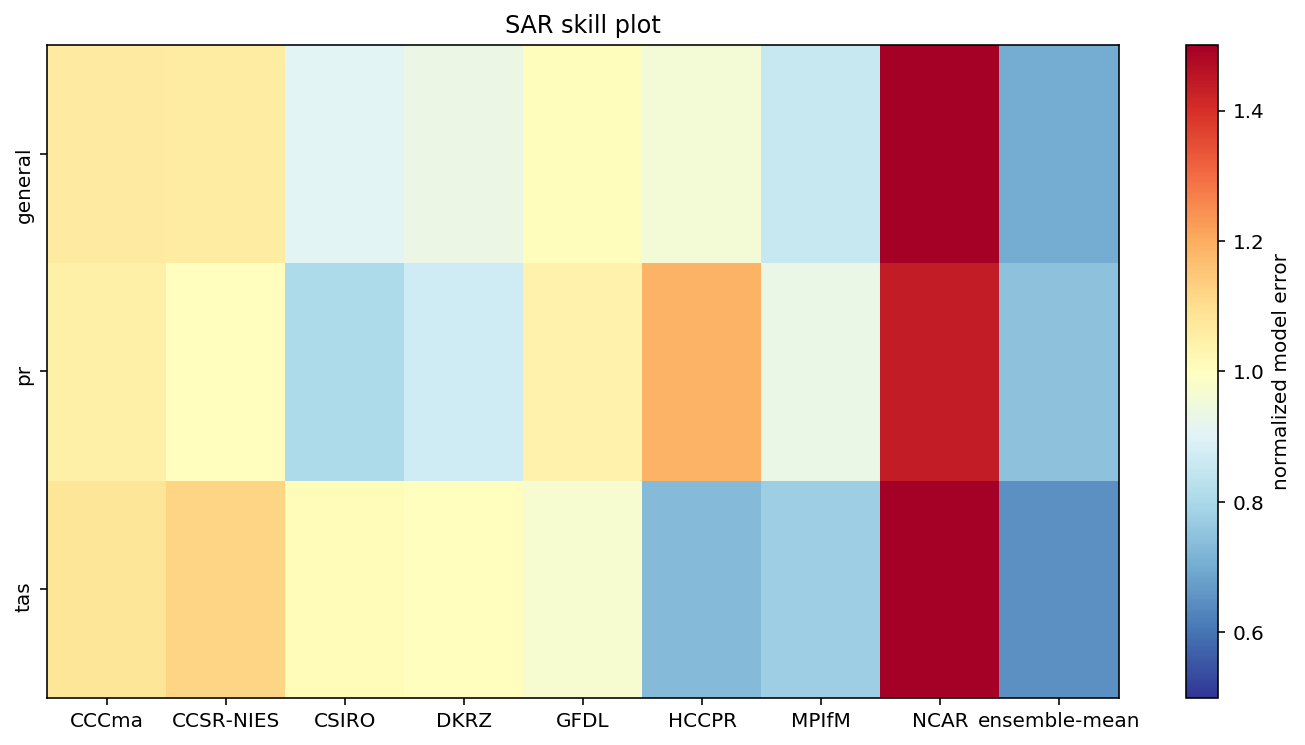

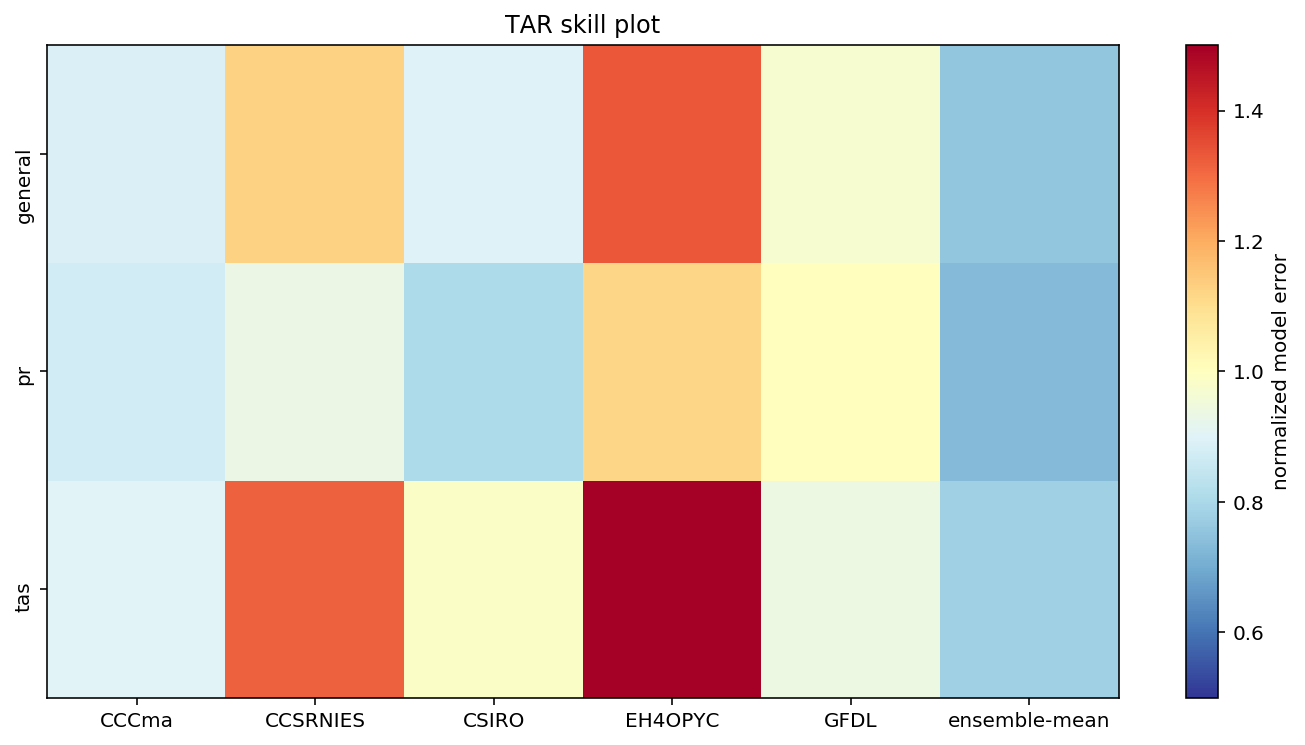

In [57]:
skill_score = rmse/SAR_rmse_med
skill_score = xr.concat(
    [skill_score, skill_score.mean(dim='var').expand_dims({'var': np.array(['general'])}, 0)],
    dim='var'
)

for mip_id in mip_ids:
    plt.figure(figsize=(12,6))
    plt.title(mip_id+" skill plot")
    non_nan_members = np.array([
        ensemble.values
        for ensemble in ens.coords['ensemble']
        if np.sum(xr.ufuncs.isnan(skill_score.sel(ensemble=ensemble, mip=mip_id))) == 0
    ])
    q = carpet_plot(skill_score.sel(mip=mip_id,ensemble=non_nan_members).drop('mip'))
    q.colorbar.set_label("normalized model error")

# Normalized Mean Absolute Error

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


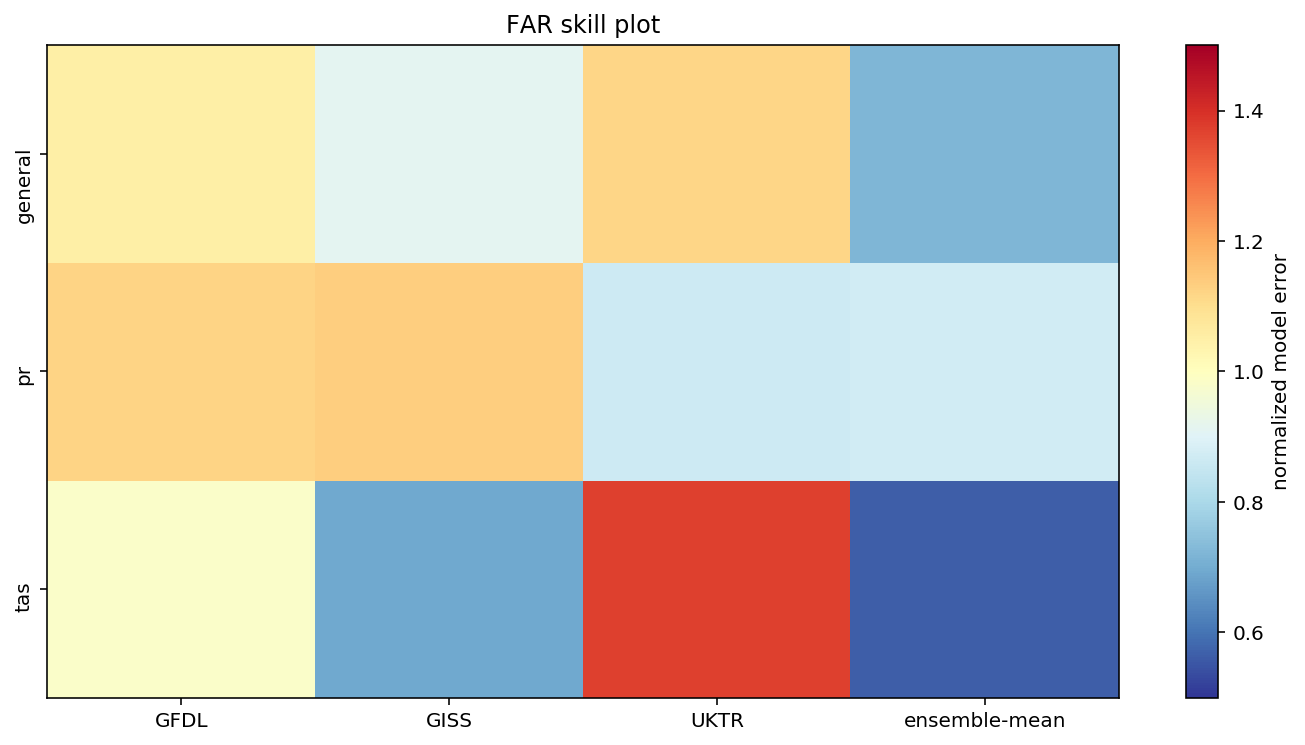

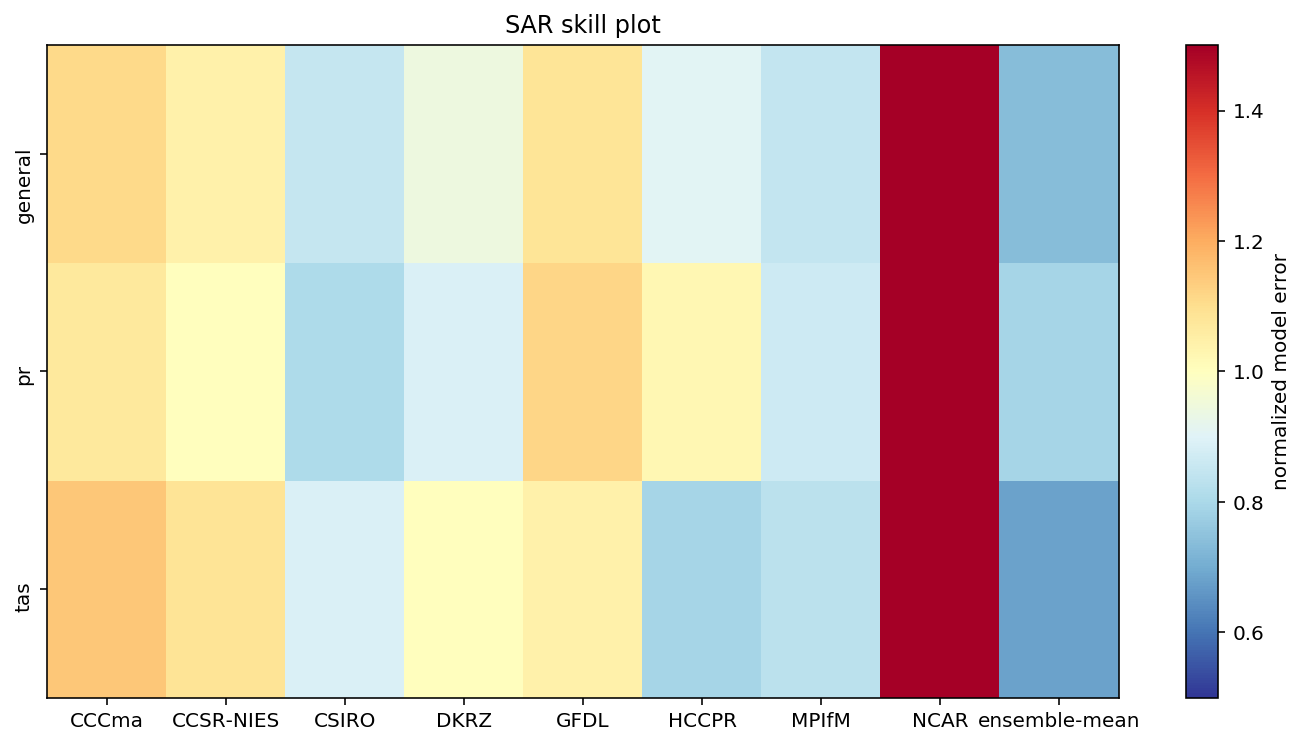

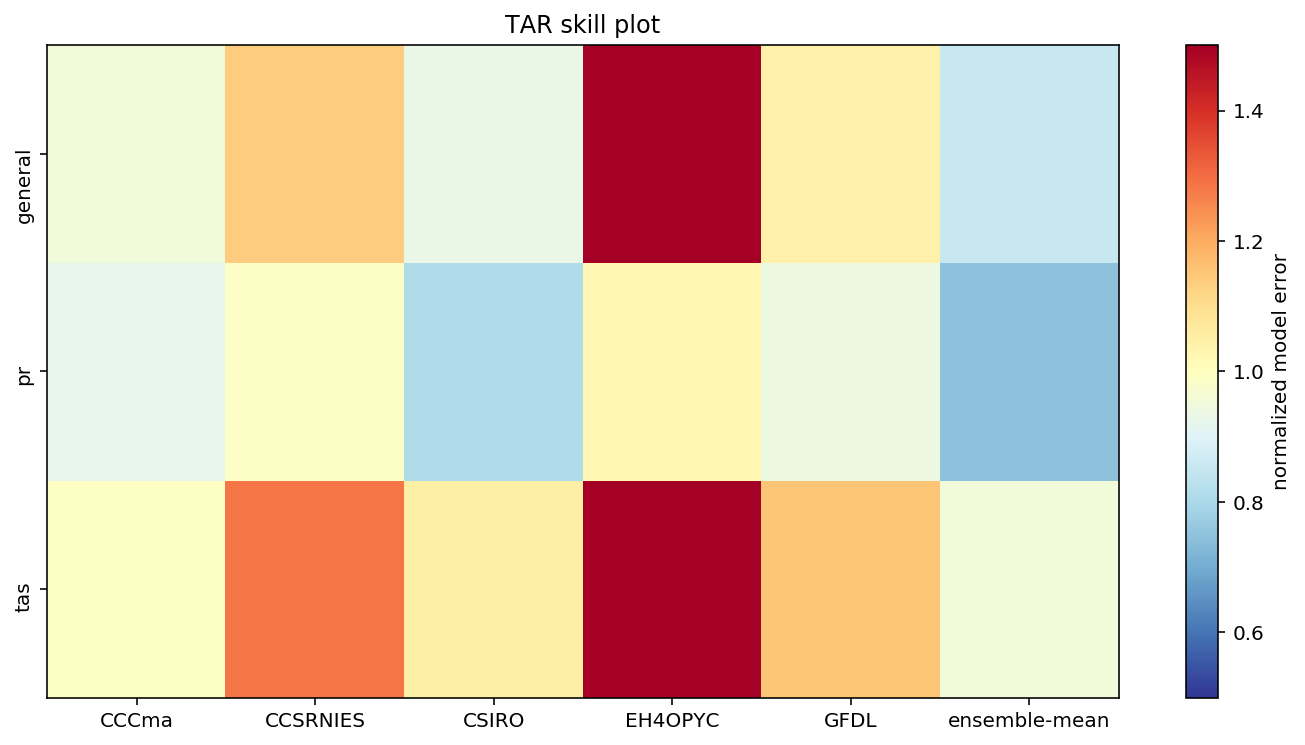

In [58]:
mae = xs.mae(ncep, ens, ['lat', 'lon']).compute()
SAR_mae_med = mae.sel(mip='SAR').median(dim='ensemble').compute()
skill_score = mae/SAR_mae_med
skill_score = xr.concat(
    [skill_score, skill_score.mean(dim='var').expand_dims({'var': np.array(['general'])}, 0)],
    dim='var'
)

for mip_id in mip_ids:
    plt.figure(figsize=(12,6))
    plt.title(mip_id+" skill plot")
    non_nan_members = np.array([
        ensemble.values
        for ensemble in ens.coords['ensemble']
        if np.sum(xr.ufuncs.isnan(skill_score.sel(ensemble=ensemble, mip=mip_id))) ==0
    ])
    q = carpet_plot(skill_score.sel(mip=mip_id,ensemble=non_nan_members).drop('mip'))
    q.colorbar.set_label("normalized model error")